In [1]:
import sys

'''
!{sys.executable}  -m pip install numba
!{sys.executable} -m pip install -e /arc/home/shiona/outriggers_vlbi_pipeline/
!{sys.executable} -m pip install -e /arc/home/shiona/coda/
!{sys.executable} -m pip install -e /arc/home/shiona/pyfx/
!{sys.executable} -m pip install pymc
!{sys.executable} -m pip install numba
!{sys.executable} -m pip install gspread_formatting
!{sys.executable} -m pip install utm

''' 
from coda.analysis.flagging import unmask_channels_single_baseline,get_optimal_rfi_mask
import numpy as np
import matplotlib.pyplot as plt
MPLSTYLE = '/arc/home/shiona/paper_sty.mplstyle'
plt.style.use(MPLSTYLE)

journal_textwidths = {'prd': 6.50127,
                      'none': 8.5,
                      'kaobook':6.5, # just a guess
                      'apj':6.0,
                      'aj': 6.0
                      } # Latex's \textwidth in inches

def figsize(fraction_of_textwidth = 0.45,height_per_width  = 1 / 1.61803399,journal = 'prd'):
    """When making your figure, decide its aspect ratio and your journal and its width as a fraction of the \textwidth of the journal. Then use matplotlib.pyplot.Figure(figsize = ...) to specify the right size"""
    textwidth = journal_textwidths[journal]
    width_in = textwidth * fraction_of_textwidth
    height_in = height_per_width * width_in
    return (width_in, height_in)

plt.rcParams["figure.figsize"] = figsize( 2 / 1.61803399,journal = 'apj')
from coda.core import VLBIVis
from outriggers_vlbi_pipeline.diagnostic_plots import plot_visibility_diagnostics
from outriggers_vlbi_pipeline.query_database import find_files
import outriggers_vlbi_pipeline.vlbi_pipeline_config as config
from glob import glob as glob


In [3]:
## here we want to calibrate the calibrators to one another and do a fringe fit 
from glob import glob
import logging
import outriggers_vlbi_pipeline
from outriggers_vlbi_pipeline.query_database import find_files
import re
from coda.core import VLBIVis
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities
import numpy as np
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities,fringefit
import coda
from coda.analysis.error_prop import get_vis_std_lag
import os
import outriggers_vlbi_pipeline.vlbi_pipeline_config as config
import argparse
import pandas as pd

def extract_info(vis,baseline,fmin=800,fmax=800):
    visbl=vis[baseline]
    mask=np.where((vis.freqs>fmin)&(vis.freqs<fmax))
    visbl['vis'][mask]=0.0

    out_dict={}
    lag,incoh_snrs=np.array(coda.analysis.delay.extract_frame_delay(vis[f'{baseline}']))
    out_dict['incoh_snr_xx']=incoh_snrs[0,0]
    out_dict['incoh_snr_yy']=incoh_snrs[1,1]
    import re
    tel1=re.split('-',baseline)[0]
    tel2=re.split('-',baseline)[-1]
    ctime=np.nanmedian(vis['chime']['time0']['ctime'][:])
    out_dict['ctime']=ctime
    out_dict['event_id']=vis.event_id
    visbl=vis[f'{baseline}']
    out_dict['ra']=vis.ra[0]
    out_dict['name']=vis[baseline].index_map['pointing_center']['source_name'][0].astype(str)
    out_dict['dec']=vis.dec[0]

    tel=coda.core.baseline.tels_to_astropy(vis[tel2]['auto'].attrs['station'])
    out_dict[ f'{tel2}_x']=tel.x.value
    out_dict[ f'{tel2}_y']=tel.y.value
    out_dict[ f'{tel2}_z']=tel.z.value

    tel=coda.core.baseline.tels_to_astropy(vis[tel1]['auto'].attrs['station'])
    out_dict[ f'{tel1}_x']=tel.x.value
    out_dict[ f'{tel1}_y']=tel.y.value
    out_dict[ f'{tel1}_z']=tel.z.value

    for key in vis[baseline]['vis'].attrs.keys():
        if 'tau' in key or 'tec' in key:
            out_dict[f'{key}_xx']=vis[baseline]['vis'].attrs[key][0]
            out_dict[f'{key}_yy']=vis[baseline]['vis'].attrs[key][1]

            if 'tec' in key:
                tecs0=vis[baseline]['vis'].attrs[key][0]
                tecs1=vis[baseline]['vis'].attrs[key][1]
                
                coda.analysis.iono.remove_tec(visbl,delta_tec=tecs0,write=True,verbose=False)
                coh_tau,coh_snrs=np.array(coda.analysis.delay.extract_subframe_delay(visbl))
                out_dict[f'snr_xx_{key}']=coh_snrs[0,0]
                coda.analysis.iono.undo_tec(visbl,verbose=False)
                coda.analysis.iono.remove_tec(visbl,delta_tec=tecs1,write=True,verbose=False)
                coh_tau,coh_snrs=np.array(coda.analysis.delay.extract_subframe_delay(visbl))
                out_dict[f'snr_yy_{key}']=coh_snrs[1,1]
                coda.analysis.iono.undo_tec(visbl,verbose=False)


    ### uncalibrated 
    if 'vis_uncalibrated' in visbl.keys():
        visbl['vis_uncalibrated'][mask]=0.0
        taus,snrs=np.array(coda.analysis.delay._extract_subframe_delay(visbl['vis_uncalibrated'][:,0,:,:,0,0]))
        out_dict['uncalibrated_snr_xx']=snrs[0,0]
        out_dict['uncaibrated_snr_yy']=snrs[1,1]

        ### calibrated but no iono fit 
        taus,snrs=np.array(coda.analysis.delay._extract_subframe_delay(visbl['vis'][:,0,:,:,0,0]))
        out_dict['calibrated_snr_xx']=snrs[0,0]
        out_dict['caibrated_snr_yy']=snrs[1,1]
        ### calibrator 
        cal_taus,cal_snrs=np.array(coda.analysis.delay._extract_subframe_delay(visbl['calibrator_vis'][:,0,:,:,0,0]))
        out_dict['cal_snr_xx']=cal_snrs[0,0]
        out_dict['cal_snr_yy']=cal_snrs[1,1]

        cal_incohtaus,cal_incohsnrs=np.array(coda.analysis.delay._extract_frame_delay(visbl['calibrator_vis'][:,0,:,:,:,0]))
        out_dict['cal_incoh_snr_xx']=cal_incohsnrs[0,0]
        out_dict['cal_incoh_snr_yy']=cal_incohsnrs[1,1]

        # additionally mask out calibrator
        mask=np.where(visbl['vis'][:]==0.0)
        visbl['calibrator_vis'][mask]=0.0

        cal_taus,cal_snrs=np.array(coda.analysis.delay._extract_subframe_delay(visbl['calibrator_vis'][:,0,:,:,0,0]))
        out_dict['cal_snr_xx_masked']=cal_snrs[0,0]
        out_dict['cal_snr_yy_masked']=cal_snrs[1,1]

        cal_incohtaus,cal_incohsnrs=np.array(coda.analysis.delay._extract_frame_delay(visbl['calibrator_vis'][:,0,:,:,:,0]))
        out_dict['cal_incoh_snr_xx_masked']=cal_incohsnrs[0,0]
        out_dict['cal_incoh_snr_yy_masked']=cal_incohsnrs[1,1]
        out_dict['calibrator_name']=visbl['calibrator_source_name'][0].astype(str)
        out_dict['calibrator_ra']=visbl['calibrator_ra'][0]
        out_dict['calibrator_dec']=visbl['calibrator_dec'][0]

    nfreq=len(np.where(np.abs(visbl['vis'][:,0,0,0,0,0])>0.0)[0])
    out_dict['bw_00']=nfreq
    nfreq=len(np.where(np.abs(visbl['vis'][:,0,1,1,0,0])>0.0)[0])
    out_dict['bw_11']=nfreq


    return out_dict

#/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112657.6+451606_calibrated_to_J112740.1+565014_vis.h5
tag=f'M21_astrometry'

baseline='chime-hco'
config_version='manual_triggers' #'hco_comissioning_rfi'
config_version='hco_comissioning_rfi' #'hco_comissioning_rfi'
config.VERSION=config_version
event_id=20250418054922#439373176
event_id=439373176#439373176

cal_files=find_files(event_id,data_type='visibilities',source_type='calibrator',filename_suffix='')
event_dir=re.split('/calibrator',cal_files[0])[0]
cal_outdir=f"{event_dir}/calibrator_calibrated_visibilities/*"
unphase_referenced_outdir=f"{event_dir}/unphase_referenced_fringefit/*"
target_check_outdir=f"{event_dir}/calibrator_calibrated_to_target_visibilities/*"
stats_outdir=f"{event_dir}/delay_stats/"
os.makedirs(stats_outdir,exist_ok=True)



### phase referenced
curr_dir=cal_outdir
print(curr_dir)

if curr_dir==cal_outdir:
    out_file1=f'{stats_outdir}{tag}_{baseline}.csv'
if curr_dir==target_check_outdir:
    out_file1=f'{stats_outdir}{tag}_target_calibrated_{baseline}.csv'
print(out_file1)

print(len(glob(curr_dir)))

out_dicts=[]
for i,file in enumerate(glob(curr_dir)):
    vis=VLBIVis.from_file(file)
    vis.attrs.filename=file
    out_dict=extract_info(vis,baseline=baseline,fmin=800,fmax=800)
    out_dict['filename']=vis.attrs.filename
    out_dicts.append(out_dict)
    
    
import pandas as pd

df = pd.DataFrame(out_dicts)
if 'calibrator_ra' in df.keys():
    import beam_model
    xs=[]
    ys=[]
    xtars=[]
    ytars=[]
    for i in range(len(df)):
        ctime=df['ctime'][i]
        ra=df['calibrator_ra'][i]#.ra.deg[0]
        dec=df['calibrator_dec'][i]#.dec.deg[0]
        x,y=beam_model.utils.get_position_from_equatorial(ra, dec,ctime)
        xs.append(x)
        ys.append(y)
        x,y=beam_model.utils.get_position_from_equatorial(df['ra'][i], df['dec'][i],ctime)
        xtars.append(x)
        ytars.append(y)
    df['x_cal']=xs
    df['y_cal']=ys
    df['x_tar']=xtars
    df['y_tar']=ytars
    df['delta_x']=df['x_tar']-df['x_cal']
    df['delta_y']=df['y_tar']-df['y_cal']
print(out_file1)
df.to_csv(out_file1)








/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/calibrator_calibrated_visibilities/*
/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_chime-hco.csv
378
Applying TEC correction (7.899999999999828 tecu)
Applying TEC correction (-3.300000000000331 tecu)
Applying TEC correction (7.899999999999828 tecu)
Applying TEC correction (-3.300000000000331 tecu)
Applying TEC correction (11.199999999999875 tecu)
Applying TEC correction (-0.3000000000002885 tecu)
Applying TEC correction (11.199999999999875 tecu)
Applying TEC correction (-0.3000000000002885 tecu)
Applying TEC correction (19.9 tecu)
Applying TEC correction (9.199999999999847 tecu)
Applying TEC correction (19.9 tecu)
Applying TEC correction (9.199999999999847 tecu)
Applying TEC correction (-2.8421709430404007e-13 tecu)
Applying TEC correction (-2.8421709430404007e-13 tecu)
Applying TEC correction (-2.8421709430404007e-13 tecu)
Applying TEC correction (-2.8421709430404


KeyboardInterrupt



In [ ]:
from ch_util import ephemeris
import ch_util
import datetime
import time
xs=[]
ys=[]
for i in range(len(df)):
    x,y=beam_model.utils.get_position_from_equatorial(df['ra'][i], df['dec'][i],ctime)
    xs.append(x)
    ys.append(y)

In [103]:
#f='/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/delay_stats/M21_astrometry_unphase_referenced_chime-hco.csv'
#f='/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/delay_stats/M21_astrometry_chime-hco.csv'
f='/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/delay_stats/M21_astrometry_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning2/2025/03/16/439373176/delay_stats/M21_astrometry_target_calibrated_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_target_calibrated_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_target_calibrated_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning2/2025/03/16/439373176/delay_stats/M21_astrometry_chime-hco.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning2/2025/03/16/439373176/delay_stats/M21_astrometry_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_chime-hco.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_chime-gbo.csv'
#f='/arc/projects/chime_frb/vlbi/hco_comissioning_rfi/2025/03/16/439373176/delay_stats/M21_astrometry_chime-hco.csv'
df=pd.read_csv(f)
#df[df['name']=='J1145+6958'][['taus_xx','calibrator_name']]



(32.0, 80.0)

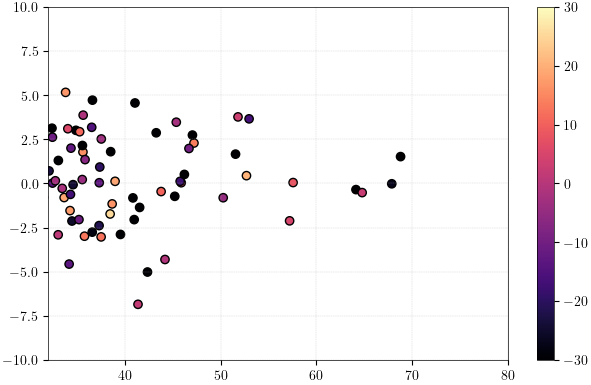

In [104]:
dfx=df.dropna().reset_index(drop=True)
#J1145+695A
dfx=dfx[dfx['name']!=dfx['calibrator_name']]
dfx=dfx[dfx['name']!='J1145+695A']
dfx=dfx[dfx['calibrator_name']!='J1145+695A']
#dfx=dfx[dfx['cal_snr_xx_masked']>14]
dfx=dfx[dfx['snr_xx_tecs']>14]
dfx=dfx.reset_index(drop=True)
#im=plt.scatter(np.sqrt(dfx['snr_xx_tecs']**2+dfx['cal_snr_xx_masked']**2),dfx['taus_xx']*1e3,c=dfx['delta_y'],vmin=-10,vmax=10)
im=plt.scatter(dfx['snr_xx_tecs'],dfx['taus_xx']*1e3,c=dfx['delta_y'],vmin=-30,vmax=30,cmap='magma',edgecolor='black')
plt.colorbar(im)
plt.ylim(-10,10)
plt.xlim(32,80)



In [105]:
df_final=dfx[dfx['snr_xx_tecs']>32].reset_index(drop=True)
df_final.to_csv('/arc/home/shiona/OVP_astrometry/notebooks/plotting_data/gbo_high_snr.csv',index=False)

In [68]:
cal_dict={}
cal_dict['J1209+4424']=[0]
cal_dict['J1212+6708']=[1] #gbo
cal_dict['J1204+5202']=[1]
cal_dict['J1153+8058']=[0]
cal_dict['J1209+2547']=[0,1]

for i in range(len(cal_dict)):
    n=list(cal_dict.keys())[i]
    if cal_dict[n]==[0]:
        print(df[df['name']==n]['taus_xx']*1e3)
    else:
        print(df[df['name']==n]['taus_yy']*1e3)


Series([], Name: taus_xx, dtype: float64)
Series([], Name: taus_yy, dtype: float64)
Series([], Name: taus_yy, dtype: float64)
34     1.530720e-11
452   -1.540000e+00
Name: taus_xx, dtype: float64
Series([], Name: taus_yy, dtype: float64)


In [69]:
dfx['name']
cal_dict={}
cal_dict['J1145+6958']=[1]
cal_dict['J1209+4424']=[0,1]

cal_dict['J1212+6708']=[0,1]
cal_dict['J1204+5202']=[0,1]

cal_dict['J2344+8226']=[1]
cal_dict['J1153+8058']=[0,1]
cal_dict['J1209+2547']=[0,1]

In [106]:
import numpy as np

def calculate_rms(data):
  """
  Calculates the root mean square (RMS) of a list or array of numbers.

  Args:
    data: A list or numpy array of numerical values.

  Returns:
    The RMS value of the data.
  """

  squared_values = np.array(data) ** 2
  mean_of_squares = np.mean(squared_values)
  rms = np.sqrt(mean_of_squares)
  return rms


In [107]:
#im=plt.scatter(dfx['snr_xx_tecs'],dfx['taus_xx']*1e3,c=dfx['delta_y'],vmin=-30,vmax=30)
#dfx.sort_values(by='snr_xx_tecs',ascending=False)['calibrator_name']


In [108]:
'''
means=[]
for source in np.unique(np.array(dfx['name'])):
    df_choice=dfx[dfx['name']==source].reset_index(drop=True)
    means.append(np.mean(df_choice['taus_xx']*1e3))
means=np.array(means)
plt.hist(means)
calculate_rms(means)
x='J1129+5638'
plt.title(x)
df_choice=dfx[dfx['name']==x]
print(np.mean(df_choice['taus_xx']*1e3))
im=plt.scatter(df_choice['tecs_xx'],df_choice['taus_xx']*1e3,c=df_choice['snr_xx_tecs'])
plt.colorbar(im)
'''

"\nmeans=[]\nfor source in np.unique(np.array(dfx['name'])):\n    df_choice=dfx[dfx['name']==source].reset_index(drop=True)\n    means.append(np.mean(df_choice['taus_xx']*1e3))\nmeans=np.array(means)\nplt.hist(means)\ncalculate_rms(means)\nx='J1129+5638'\nplt.title(x)\ndf_choice=dfx[dfx['name']==x]\nprint(np.mean(df_choice['taus_xx']*1e3))\nim=plt.scatter(df_choice['tecs_xx'],df_choice['taus_xx']*1e3,c=df_choice['snr_xx_tecs'])\nplt.colorbar(im)\n"

In [109]:
dfx_error=np.abs(dfx['taus_xx']*1e3)
dfx['error_abs']=dfx_error
df_final=dfx[dfx['snr_xx_tecs']>32]
#df_final=df_final[np.abs(df_final['delta_y'])<100]
print(len(df_final))
print(calculate_rms(df_final['taus_xx']*1e3))
print(len(dfx))
print(calculate_rms(dfx['taus_xx']*1e3))

68
2.816686361459502
270
6.732845966962106


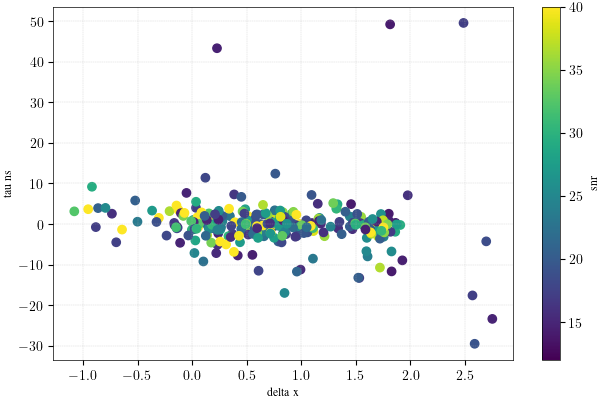

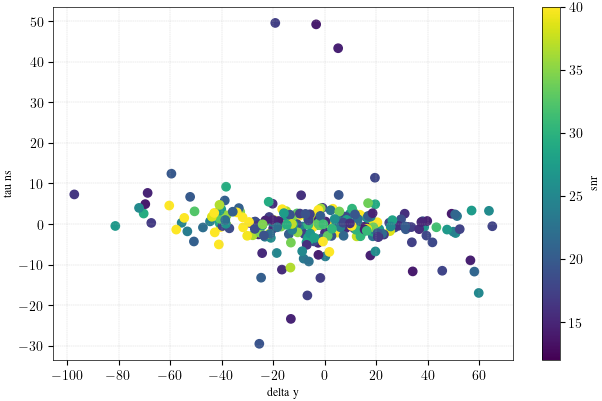

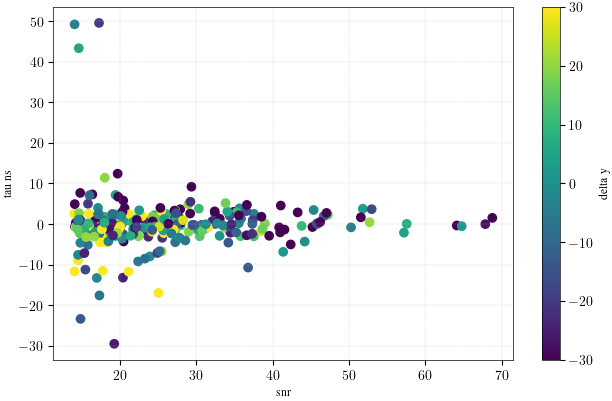

In [110]:
im=plt.scatter(dfx['delta_x'],dfx['taus_xx']*1e3,c=dfx['snr_xx_tecs'],vmin=12,vmax=40)
cbar=plt.colorbar(im)
cbar.set_label('snr')
plt.xlabel('delta x')
plt.ylabel('tau ns')
plt.show()

im=plt.scatter(dfx['delta_y'],dfx['taus_xx']*1e3,c=dfx['snr_xx_tecs'],vmin=12,vmax=40)
cbar=plt.colorbar(im)
cbar.set_label('snr')
plt.xlabel('delta y')
plt.ylabel('tau ns')
plt.show()


im=plt.scatter(dfx['snr_xx_tecs'],dfx['taus_xx']*1e3,c=dfx['delta_y'],vmin=-30,vmax=30)
cbar=plt.colorbar(im)
cbar.set_label('delta y')
plt.xlabel('snr')
plt.ylabel('tau ns')
plt.show()



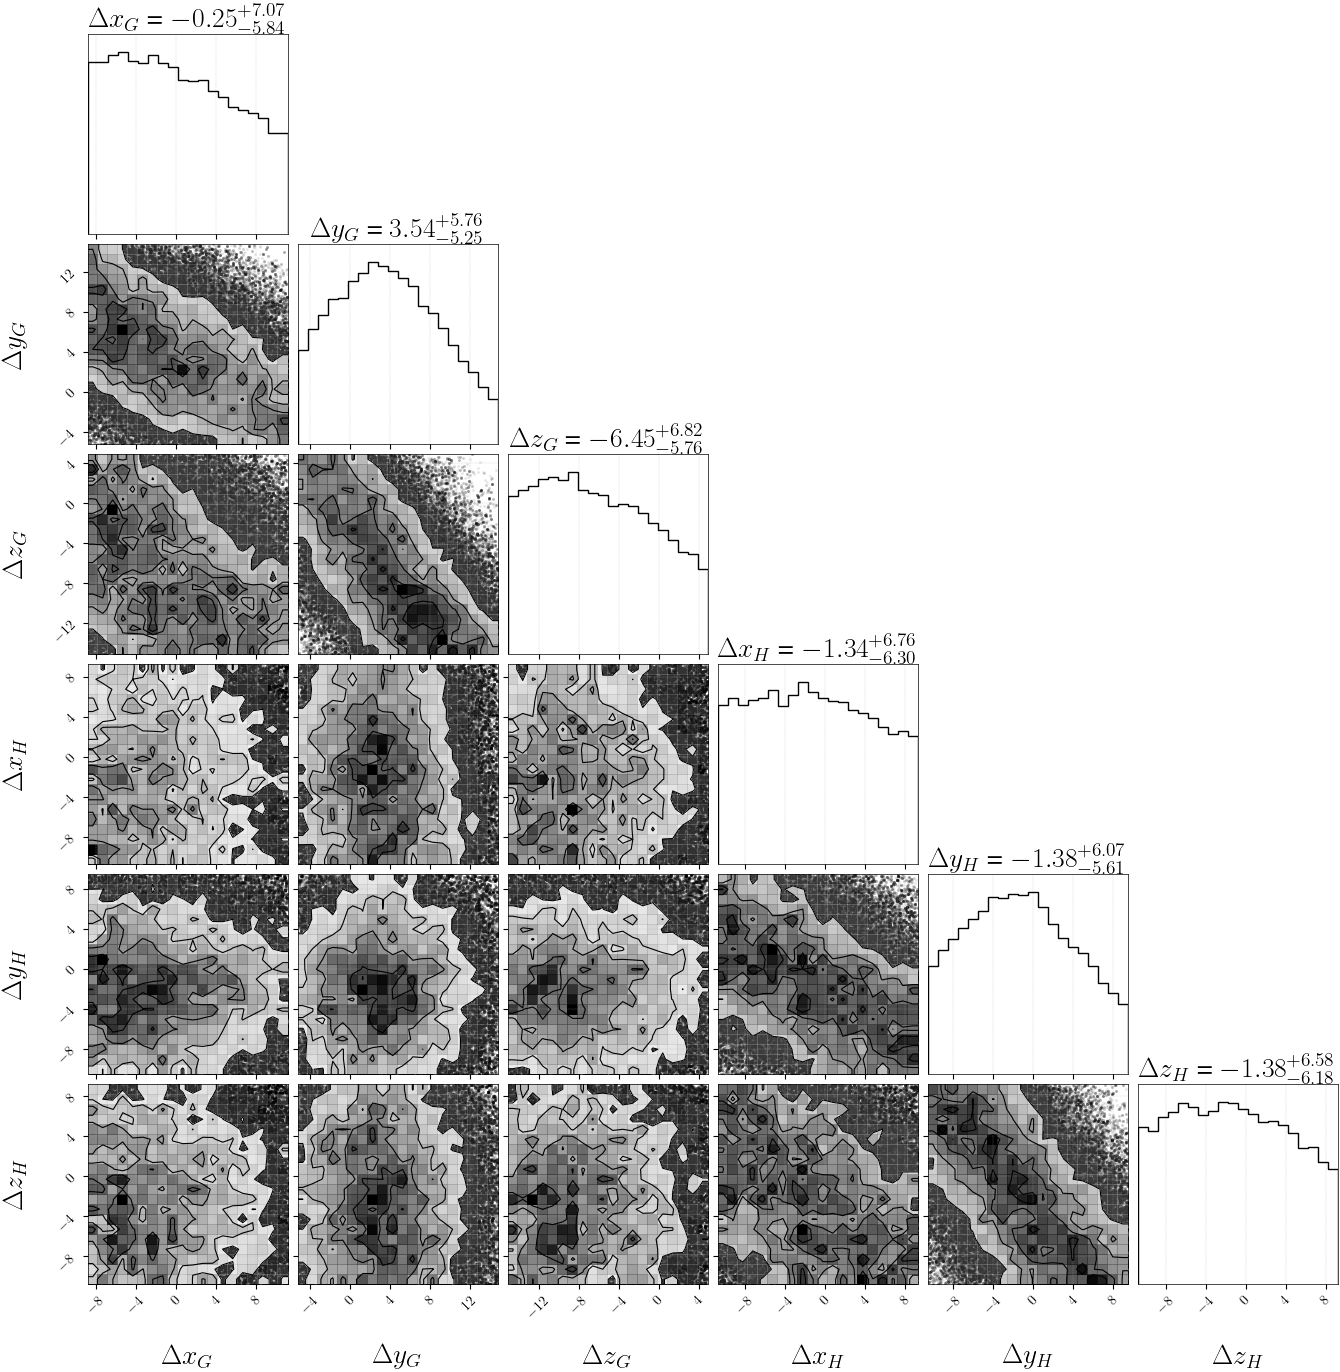

In [416]:
import numpy as np
import matplotlib.pyplot as plt
samples=np.load('joint_mcmc_fit_12.npy')

import corner
#corner.corner(samples, labels=["x", "y", "z"], truths=best_fit)
#plt.show()

import corner
import matplotlib.pyplot as plt
samples[:,0]-=gbo.x.value
samples[:,1]-=gbo.y.value
samples[:,2]-=gbo.z.value
samples[:,3]-=hco.x.value
samples[:,4]-=hco.y.value
samples[:,5]-=hco.z.value
# Assuming 'samples' is your (n_samples, n_dim) MCMC output
figure = corner.corner(samples, labels=[r"$\Delta x_{G}$", r"$\Delta y_{G}$", r"$\Delta z_{G}$",r"$\Delta x_{H}$", r"$\Delta y_{H}$", r"$\Delta z_{H}$"], 
                        show_titles=True, title_fmt=".2f")

for ax in figure.get_axes():
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
        
plt.show()


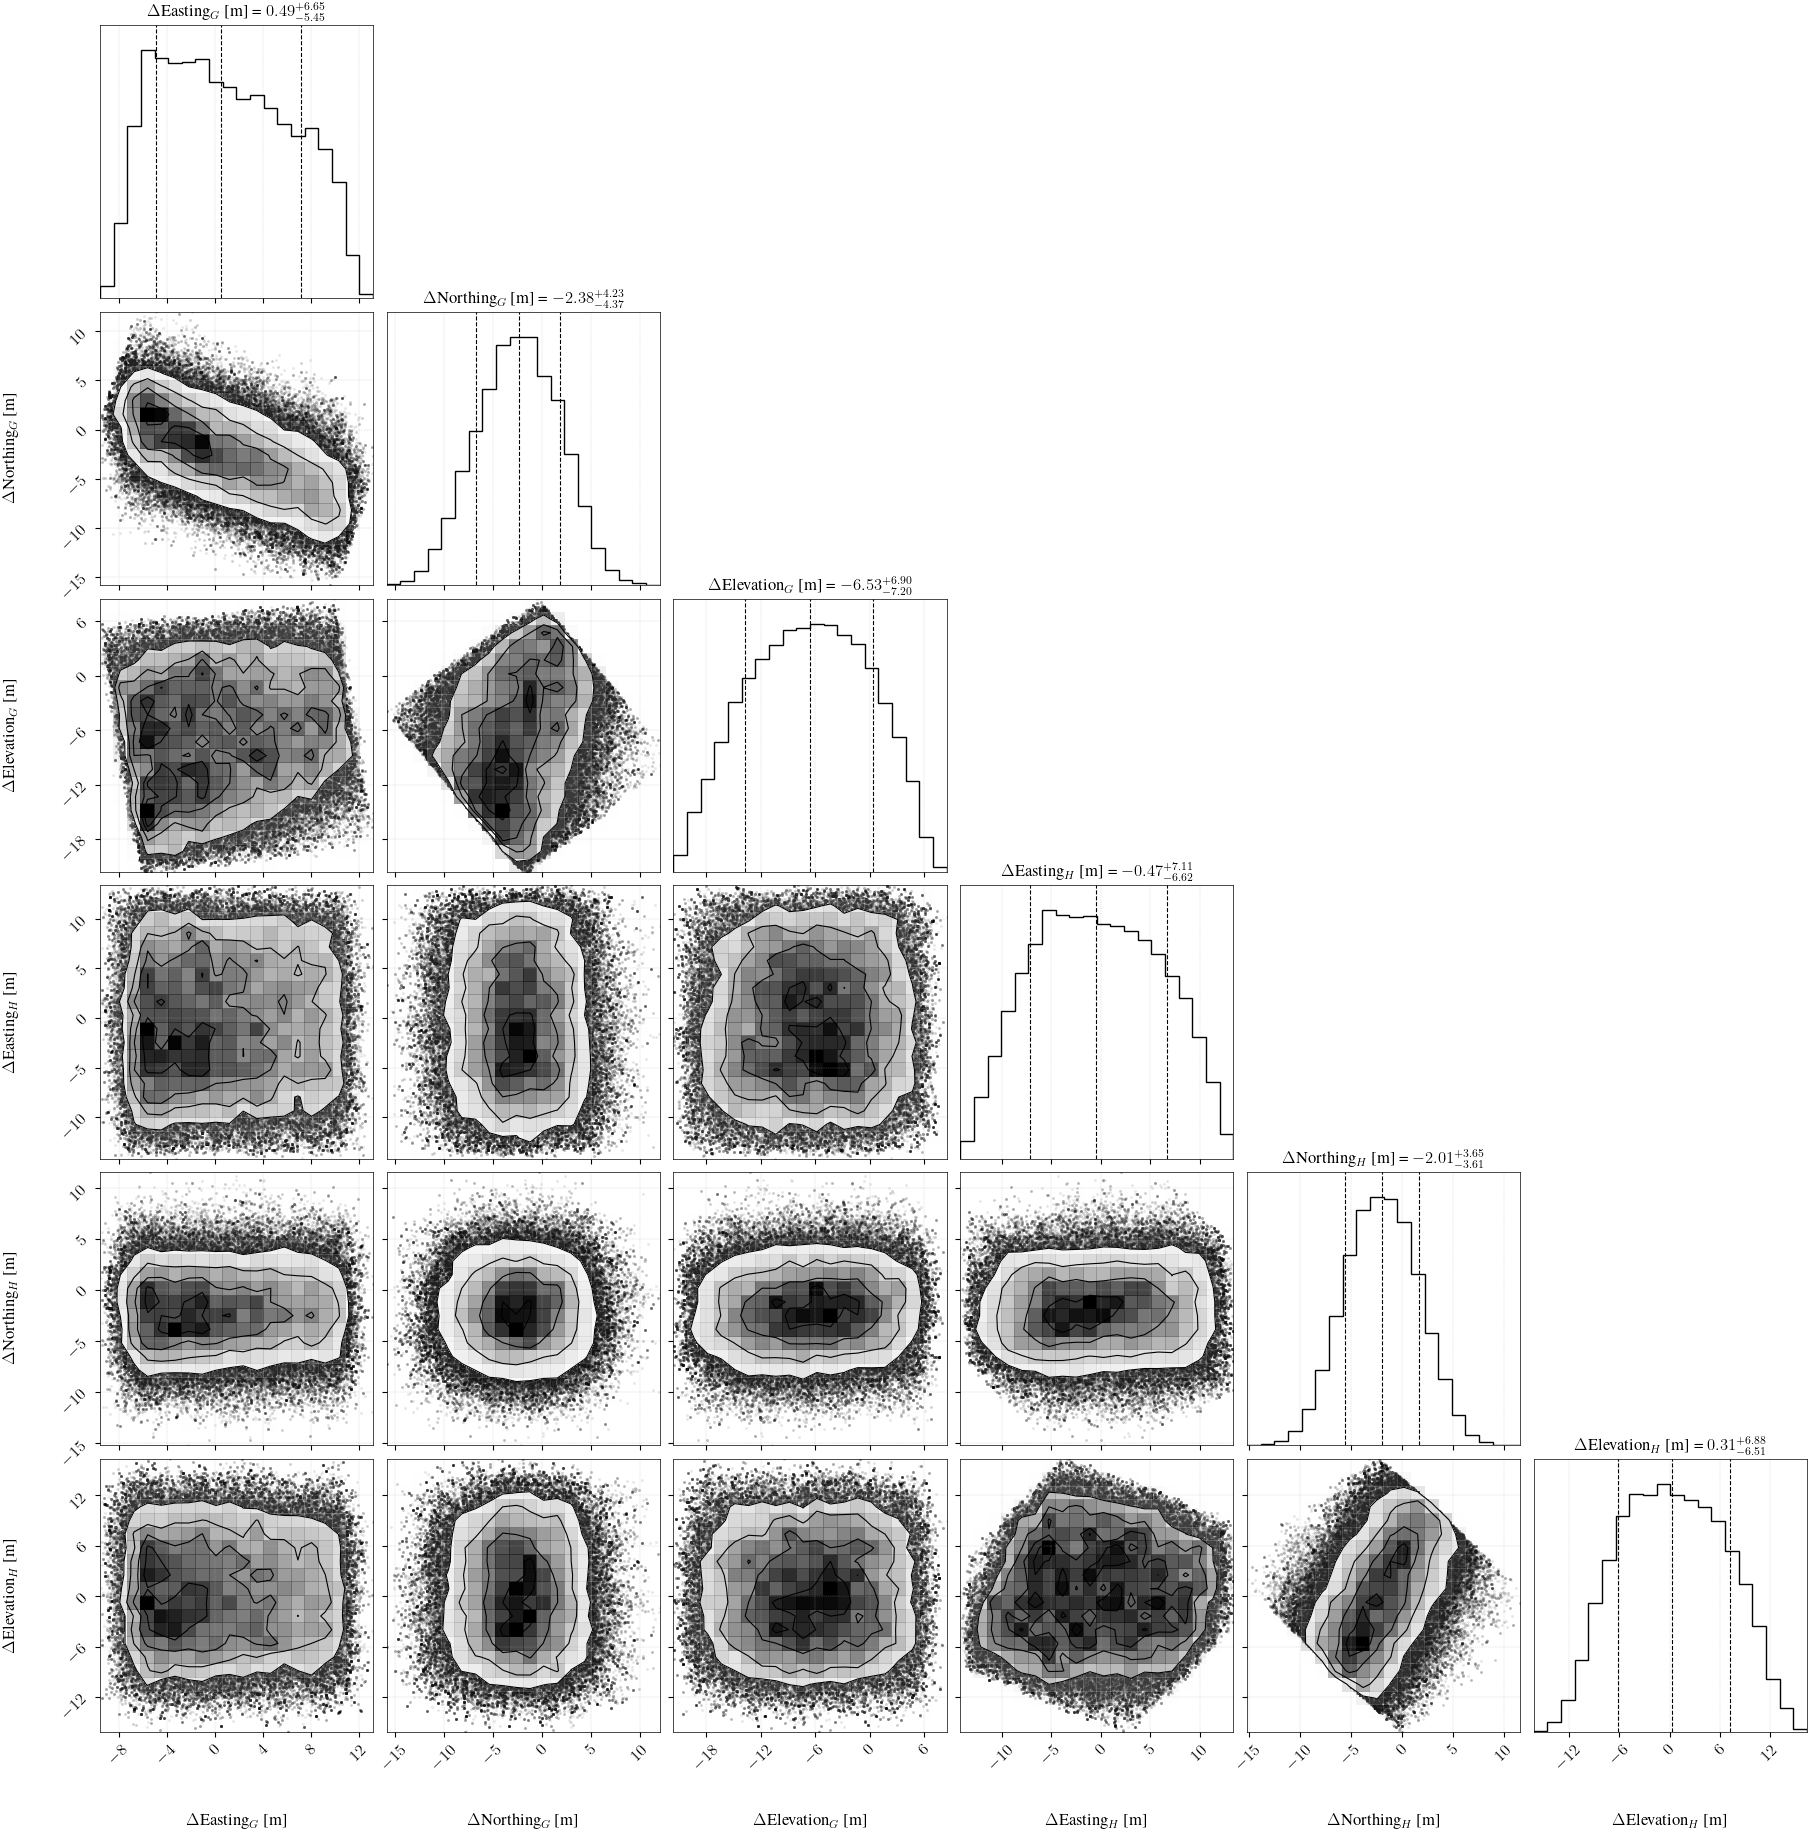

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import astropy.units as un
import astropy.coordinates as ac
import utm

# Load MCMC samples
samples = np.load('joint_mcmc_fit_12.npy')


# Convert ECEF samples to EarthLocation
gbo_samples = ac.EarthLocation(
    x=samples[:, 0]*un.m,
    y=samples[:, 1]*un.m,
    z=samples[:, 2]*un.m
)
hco_samples = ac.EarthLocation(
    x=samples[:, 3]*un.m,
    y=samples[:, 4]*un.m,
    z=samples[:, 5]*un.m
)

# Convert GBO and HCO to geodetic and UTM
gbo_geo = gbo.to_geodetic()
gbo_utm = utm.from_latlon(gbo_geo.lat.deg, gbo_geo.lon.deg)

hco_geo = hco.to_geodetic()
hco_utm = utm.from_latlon(hco_geo.lat.deg, hco_geo.lon.deg)

# Convert samples to geodetic
gbo_samples_geo = gbo_samples.to_geodetic()
hco_samples_geo = hco_samples.to_geodetic()

# Convert to UTM
gbo_samples_utm = np.array([utm.from_latlon(lat, lon)[:2] for lat, lon in zip(gbo_samples_geo.lat.deg, gbo_samples_geo.lon.deg)])
hco_samples_utm = np.array([utm.from_latlon(lat, lon)[:2] for lat, lon in zip(hco_samples_geo.lat.deg, hco_samples_geo.lon.deg)])

# Compute relative displacements
gbo_easting = gbo_samples_utm[:, 0] - gbo_utm[0]
gbo_northing = gbo_samples_utm[:, 1] - gbo_utm[1]
gbo_height = gbo_samples_geo.height.value - gbo_geo.height.value

hco_easting = hco_samples_utm[:, 0] - hco_utm[0]
hco_northing = hco_samples_utm[:, 1] - hco_utm[1]
hco_height = hco_samples_geo.height.value - hco_geo.height.value

# Combine into array for plotting
flat_samples_utm = np.zeros_like(samples)
flat_samples_utm[:, 0] = gbo_easting
flat_samples_utm[:, 1] = gbo_northing
flat_samples_utm[:, 2] = gbo_height
flat_samples_utm[:, 3] = hco_easting
flat_samples_utm[:, 4] = hco_northing
flat_samples_utm[:, 5] = hco_height

# Plot
labels = [
    r'$\Delta$Easting$_{GBO}$ [m]', r'$\Delta$Northing$_{GBO}$ [m]', r'$\Delta$Elevation$_{GBO}$ [m]',
    r'$\Delta$Easting$_{HCO}$ [m]', r'$\Delta$Northing$_{HCO}$ [m]', r'$\Delta$Elevation$_{HCO}$ [m]'
]

fig = corner.corner(flat_samples_utm, labels=labels, show_titles=True, title_fmt='.2f', quantiles=[0.16, 0.5, 0.84], max_n_ticks=6, fontsize=14)
fig.subplots_adjust(right=1.3, top=1.3)

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=12)

plt.savefig('corner_utm.png', bbox_inches='tight', dpi=200)
plt.show()


In [ ]:
#config.VERSION='manual_triggers'


from coda.analysis.flagging import get_optimal_rfi_mask

sources=['J1135+4258','J1145+6958','J1153+8058']
source=sources[0]
file=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/*{source}*')[0]
cal_vis=VLBIVis.from_file(file)
for key in cal_vis.keys():
    if 'gbo-hco' in key:
        print(key)
        mask=np.where((vis.freqs>750))
        cal_vis[key]['vis'][mask]=0.0
        mask=np.where((vis.freqs>580)&(vis.freqs<600))
        cal_vis[key]['vis'][mask]=0.0
        mask=np.where((vis.freqs>510)&(vis.freqs<540))
        cal_vis[key]['vis'][mask]=0.0
        get_optimal_rfi_mask(cal_vis[key],write=True)
        
files=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/*')
print(len(files))
target_files=[]
for f in files:
    if source not in f:
        print(f)
        target_files.append(f)
print(len(target_files))
for tar_file in target_files:
    vis_target=VLBIVis.from_file(tar_file)
    key='gbo-hco'
    print(key)
    mask=np.where((vis_target.freqs>750))
    vis_target[key]['vis'][mask]=0.0
    mask=np.where((vis_target.freqs>580)&(vis.freqs<600))
    vis_target[key]['vis'][mask]=0.0
    mask=np.where((vis_target.freqs>510)&(vis.freqs<540))
    vis_target[key]['vis'][mask]=0.0
    get_optimal_rfi_mask(vis_target[key],write=True)
    create_calibrated_visibilities([cal_vis],vis_target,out_dir='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/')

        

In [159]:


from coda.analysis.flagging import get_optimal_rfi_mask

sources=['J1135+4258','J1145+6958','J1153+8058']
source=sources[0]
eid=20250418054922
file=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/*{source}*')[0]
cal_vis=VLBIVis.from_file(file)
for key in cal_vis.keys():
    if 'gbo-hco' in key:
        print(key)
        mask=np.where((vis.freqs>750))
        cal_vis[key]['vis'][mask]=0.0
        mask=np.where((vis.freqs>580)&(vis.freqs<600))
        cal_vis[key]['vis'][mask]=0.0
        mask=np.where((vis.freqs>510)&(vis.freqs<540))
        cal_vis[key]['vis'][mask]=0.0
        get_optimal_rfi_mask(cal_vis[key],write=True)
        
files=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/*{sources[-1]}*')
print(len(files))
target_files=[]
for f in files:
    if source not in f:
        print(f)
        target_files.append(f)
print(len(target_files))
for tar_file in target_files:
    vis_target=VLBIVis.from_file(tar_file)
    key='gbo-hco'
    print(key)
    mask=np.where((vis_target.freqs>750))
    vis_target[key]['vis'][mask]=0.0
    mask=np.where((vis_target.freqs>580)&(vis.freqs<600))
    vis_target[key]['vis'][mask]=0.0
    mask=np.where((vis_target.freqs>510)&(vis.freqs<540))
    vis_target[key]['vis'][mask]=0.0
    get_optimal_rfi_mask(vis_target[key],write=True)
    create_calibrated_visibilities([cal_vis],vis_target,out_dir=f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/{eid}/')

        

gbo-hco
5.500061


[2025-05-19 14:50:01,227] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.758522
1
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1153+8058_vis.h5
1
gbo-hco
6.6691513


[2025-05-19 14:50:14,690] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.814064


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 14:50:15,993] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
writing vis_error to container
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 14:50:16,190] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 14:50:16,576] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 14:50:18,549] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, o

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 14:50:18,896] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 14:50:20,621] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 14:50:20,933] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [163]:

    
from coda.analysis.flagging import get_optimal_rfi_mask

sources=['J1145+6958','J1135+4258']
source=sources[1]
eid=20250418054922
file=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/*{source}*')[0]
cal_vis=VLBIVis.from_file(file)

files=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/**')
print(len(files))
target_files=[]
for f in files:
    if source not in f:
        print(f)
        target_files.append(f)
print(len(target_files))
for tar_file in target_files:
    vis_target=VLBIVis.from_file(tar_file)
    key='gbo-hco'
    print(key)
    mask=np.where((vis_target.freqs>720))
    vis_target[key]['vis'][mask]=0.0
    #mask=np.where((vis_target.freqs>550)&(vis.freqs<600))
    #vis_target[key]['vis'][mask]=0.0
    #unmask_channels_single_baseline(vis['gbo-hco'])
    get_optimal_rfi_mask(vis_target[key],write=True)
    create_calibrated_visibilities([cal_vis],vis_target,out_dir=f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/{eid}/')

        

36
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1136+7009_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1132+6324_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1153+8058_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1104+7932_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1145+695A_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1135+3708_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1140+4022_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/202504

[2025-05-19 15:39:46,402] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.6814003


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:39:47,469] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1136+7009_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
writing vis_error to container
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:39:47,751] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:39:48,167] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:39:50,131] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:39:50,490] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:39:52,523] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:39:52,920] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.0585213


[2025-05-19 15:40:11,024] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.6992836


[2025-05-19 15:40:11,948] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:40:11,978] INFO phase template already exists, will not overwrite
[2025-05-19 15:40:12,008] INFO phase template already exists, will not overwrite
[2025-05-19 15:40:12,019] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:40:12,180] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:12,514] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:40:14,405] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:14,880] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:40:16,830] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:17,137] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
7.0915985


[2025-05-19 15:40:35,321] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.057003


[2025-05-19 15:40:36,178] INFO phase template already exists, will not overwrite
[2025-05-19 15:40:36,215] INFO phase template already exists, will not overwrite
[2025-05-19 15:40:36,252] INFO phase template already exists, will not overwrite
[2025-05-19 15:40:36,264] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:40:36,446] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:36,899] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:40:39,271] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:39,574] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:40:41,315] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:40:41,637] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.3861427


[2025-05-19 15:40:58,988] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.807087


[2025-05-19 15:41:00,482] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:00,510] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:00,538] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:00,549] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1104+7932_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:41:00,703] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:01,021] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:41:02,931] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:03,249] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:41:05,251] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:05,568] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5170174


[2025-05-19 15:41:25,392] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.316036


[2025-05-19 15:41:27,256] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:41:27,286] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:27,312] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:27,322] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:41:27,476] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:41:27,812] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:41:29,694] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:30,016] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:41:31,946] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:32,264] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
8.059219


[2025-05-19 15:41:48,574] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.0523453


[2025-05-19 15:41:49,462] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:49,501] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:49,540] INFO phase template already exists, will not overwrite
[2025-05-19 15:41:49,553] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:41:49,853] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:50,212] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:41:52,047] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:52,361] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:41:54,143] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:41:54,461] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.893715


[2025-05-19 15:42:10,833] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.3904915


[2025-05-19 15:42:11,580] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:11,624] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:11,649] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:11,659] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4022_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:42:11,980] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:42:12,290] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:42:14,081] INFO adding vis error in vlbivis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:1016: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(6*npol, 6))


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:42:14,387] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:42:16,180] INFO adding vis error in vlbivis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:494: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(15, 18))


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:42:16,484] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.931484


[2025-05-19 15:42:34,604] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.698948


[2025-05-19 15:42:35,536] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:42:35,579] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:35,621] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:35,636] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5638_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:42:35,833] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:42:36,343] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:42:38,511] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:42:40,276] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:42:40,592] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.92593


[2025-05-19 15:42:57,734] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.244816


[2025-05-19 15:42:58,479] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:42:58,520] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:58,562] INFO phase template already exists, will not overwrite
[2025-05-19 15:42:58,576] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5025_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:42:58,768] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:42:59,265] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:01,514] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:43:03,299] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:03,607] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.88657


[2025-05-19 15:43:19,600] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.926304


[2025-05-19 15:43:20,498] INFO phase template already exists, will not overwrite
[2025-05-19 15:43:20,530] INFO phase template already exists, will not overwrite
[2025-05-19 15:43:20,561] INFO phase template already exists, will not overwrite
[2025-05-19 15:43:20,573] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1125+5000_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:43:20,735] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:21,078] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:43:23,568] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:24,059] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:43:26,325] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:33,279] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
6.118202


[2025-05-19 15:43:51,977] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.892765


[2025-05-19 15:43:52,752] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:43:52,791] INFO phase template already exists, will not overwrite
[2025-05-19 15:43:52,828] INFO phase template already exists, will not overwrite
[2025-05-19 15:43:52,840] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+4051_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:43:53,101] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:43:53,456] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:43:55,524] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:55,854] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:43:57,960] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:43:58,300] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.7337265


[2025-05-19 15:44:16,287] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.7512665


[2025-05-19 15:44:17,435] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:17,482] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:17,528] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:17,544] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:44:17,745] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:18,253] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:44:20,606] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:21,108] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:44:24,120] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:24,628] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.473545


[2025-05-19 15:44:42,883] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4115868


[2025-05-19 15:44:43,563] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:43,595] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:43,629] INFO phase template already exists, will not overwrite
[2025-05-19 15:44:43,641] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1137+3950_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:44:43,791] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:44,134] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:44:46,474] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:46,825] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:44:48,863] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:44:49,217] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.019802


[2025-05-19 15:45:10,375] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.07098


[2025-05-19 15:45:11,045] INFO phase template already exists, will not overwrite
[2025-05-19 15:45:11,076] INFO phase template already exists, will not overwrite
[2025-05-19 15:45:11,109] INFO phase template already exists, will not overwrite
[2025-05-19 15:45:11,120] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1138+2524_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:45:11,283] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:45:11,619] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:45:13,624] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:45:13,949] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:45:15,899] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:45:16,247] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.615341


[2025-05-19 15:45:35,345] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.0146446


[2025-05-19 15:45:35,989] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:45:36,039] INFO phase template already exists, will not overwrite
[2025-05-19 15:45:36,088] INFO phase template already exists, will not overwrite
[2025-05-19 15:45:36,103] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1136+5643_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:45:36,384] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:45:36,839] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:45:39,461] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:45:41,898] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:45:42,228] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.453312


[2025-05-19 15:45:59,817] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.2576294


[2025-05-19 15:46:00,655] INFO phase template already exists, will not overwrite
[2025-05-19 15:46:00,685] INFO phase template already exists, will not overwrite
[2025-05-19 15:46:00,714] INFO phase template already exists, will not overwrite
[2025-05-19 15:46:00,723] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+3803_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:46:00,917] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:46:01,291] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:46:03,434] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:46:03,750] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:46:08,151] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:46:08,514] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.769184


[2025-05-19 15:46:29,051] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.5340652


[2025-05-19 15:46:29,729] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:46:29,767] INFO phase template already exists, will not overwrite
[2025-05-19 15:46:29,802] INFO phase template already exists, will not overwrite
[2025-05-19 15:46:29,817] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1131+4514_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:46:30,269] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:46:30,861] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:46:34,338] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:46:36,835] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:46:37,196] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
7.0243874


[2025-05-19 15:47:54,571] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4128304


[2025-05-19 15:47:55,598] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:47:55,632] INFO phase template already exists, will not overwrite
[2025-05-19 15:47:55,664] INFO phase template already exists, will not overwrite
[2025-05-19 15:47:55,676] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5743_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:47:55,830] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:47:56,178] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:48:11,703] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:48:18,599] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:48:24,792] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:48:25,132] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.7418594


[2025-05-19 15:49:35,659] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.813801


[2025-05-19 15:49:36,550] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:49:36,582] INFO phase template already exists, will not overwrite
[2025-05-19 15:49:36,611] INFO phase template already exists, will not overwrite
[2025-05-19 15:49:36,622] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1133+0015_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:49:36,802] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:49:37,132] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:49:39,033] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:49:39,352] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:49:41,585] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:49:41,935] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.912075


[2025-05-19 15:50:33,797] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.9277496


[2025-05-19 15:50:38,099] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)


Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated


[2025-05-19 15:50:38,608] INFO phase template already exists, will not overwrite


Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:50:39,098] INFO phase template already exists, will not overwrite
[2025-05-19 15:50:39,203] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J2344+8226_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:50:42,610] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:50:43,291] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:50:58,084] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:50:59,943] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:51:00,268] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
8.0997505


[2025-05-19 15:52:31,706] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.699417


[2025-05-19 15:52:34,401] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:52:34,805] INFO phase template already exists, will not overwrite


Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:52:35,414] INFO phase template already exists, will not overwrite
[2025-05-19 15:52:35,603] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+5912_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:52:37,618] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:52:38,192] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:52:52,992] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:53:07,352] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:53:07,662] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.4568214


[2025-05-19 15:54:30,341] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.74004


[2025-05-19 15:54:32,205] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:54:32,708] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:54:33,208] INFO phase template already exists, will not overwrite
[2025-05-19 15:54:33,397] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4657_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:54:35,697] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:54:41,997] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:54:56,405] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:55:00,784] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:55:07,109] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:55:13,111] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.4598656


[2025-05-19 15:56:31,708] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.7991333


[2025-05-19 15:56:35,307] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated


[2025-05-19 15:56:36,010] INFO phase template already exists, will not overwrite


Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:56:36,515] INFO phase template already exists, will not overwrite
[2025-05-19 15:56:36,705] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+3815_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:56:38,521] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:56:39,104] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:57:04,817] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:57:13,799] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:57:20,199] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
6.434429


[2025-05-19 15:58:48,758] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.0482864


[2025-05-19 15:58:49,533] INFO phase template already exists, will not overwrite
[2025-05-19 15:58:49,576] INFO phase template already exists, will not overwrite
[2025-05-19 15:58:49,615] INFO phase template already exists, will not overwrite
[2025-05-19 15:58:49,629] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+5300_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:58:50,609] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:58:57,798] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:59:14,599] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:59:19,442] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 15:59:33,499] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:59:34,277] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.729328


[2025-05-19 16:00:05,017] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.111664


[2025-05-19 16:00:06,009] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:00:06,039] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:06,070] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:06,082] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1126+3345_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:00:06,309] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:00:06,646] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 16:00:08,398] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:00:08,710] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:00:10,578] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:00:10,889] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5972557


[2025-05-19 16:00:29,046] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.1980896


[2025-05-19 16:00:29,939] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:00:29,972] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:30,004] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:30,016] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:00:30,194] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:00:30,534] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 16:00:33,270] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:00:33,632] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:00:36,008] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:00:36,368] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5989113


[2025-05-19 16:00:55,604] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.925827


[2025-05-19 16:00:56,375] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:00:56,424] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:56,476] INFO phase template already exists, will not overwrite
[2025-05-19 16:00:56,495] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+7654_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:00:56,706] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:00:57,251] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:00:59,847] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:01:02,015] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:01:02,372] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.2693634


[2025-05-19 16:01:22,078] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.1919365


[2025-05-19 16:01:23,111] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:01:23,159] INFO phase template already exists, will not overwrite
[2025-05-19 16:01:23,209] INFO phase template already exists, will not overwrite
[2025-05-19 16:01:23,229] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3010_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:01:23,447] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:01:23,929] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:01:26,214] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:01:28,123] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:01:28,435] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.8051186


[2025-05-19 16:02:01,586] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4229164


[2025-05-19 16:02:03,705] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)


Applying phase cal


[2025-05-19 16:02:04,305] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:02:04,901] INFO phase template already exists, will not overwrite
[2025-05-19 16:02:05,099] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+4032_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:02:07,097] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:02:10,613] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:02:18,967] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:02:30,401] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:02:31,620] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.96793


[2025-05-19 16:03:42,605] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.199932


[2025-05-19 16:03:44,904] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:03:44,950] INFO phase template already exists, will not overwrite
[2025-05-19 16:03:44,994] INFO phase template already exists, will not overwrite
[2025-05-19 16:03:45,010] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J0117+8928_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:03:45,192] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:03:45,613] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 16:03:54,358] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:03:56,213] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:04:02,542] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:04:02,857] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.4717407


[2025-05-19 16:05:14,096] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.301586


[2025-05-19 16:05:18,003] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:05:18,506] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:05:19,097] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:05:19,296] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5
[2025-05-19 16:05:20,849] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:05:21,807] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+6958_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:05:29,797] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+6958_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:05:41,860] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:05:43,701] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+6958_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
6.507862


[2025-05-19 16:07:11,411] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.89682


[2025-05-19 16:07:12,627] INFO phase template already exists, will not overwrite
[2025-05-19 16:07:12,658] INFO phase template already exists, will not overwrite
[2025-05-19 16:07:12,689] INFO phase template already exists, will not overwrite
[2025-05-19 16:07:12,700] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+0110_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:07:12,867] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:07:13,221] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 16:07:22,357] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:07:25,838] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:07:30,920] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:07:34,709] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
4.8632584


[2025-05-19 16:08:50,062] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.699131


[2025-05-19 16:08:51,298] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:08:51,809] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:08:52,299] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:08:52,411] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1128+5925_calibrated_to_J1135+4258_vis.h5
[2025-05-19 16:08:53,841] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:08:57,199] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1135+4258_chime-gbo_visibility_diagnostics.png
[2025-05-19 16:09:00,912] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:09:03,382] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:09:15,108] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:09:15,471] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.004608


[2025-05-19 16:10:21,608] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.031582


[2025-05-19 16:10:23,409] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:10:23,798] INFO phase template already exists, will not overwrite


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:10:24,211] INFO phase template already exists, will not overwrite
[2025-05-19 16:10:24,398] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5650_calibrated_to_J1135+4258_vis.h5


writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:10:25,805] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:10:26,332] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:10:42,103] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:10:45,706] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:10:49,438] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


gbo-hco
5.2891006


[2025-05-19 16:12:11,667] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.209198


[2025-05-19 16:12:12,640] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 16:12:12,685] INFO phase template already exists, will not overwrite
[2025-05-19 16:12:12,736] INFO phase template already exists, will not overwrite
[2025-05-19 16:12:12,752] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1141+6410_calibrated_to_J1135+4258_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 16:12:13,565] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 16:12:17,406] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1135+4258_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:12:30,727] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1135+4258_chime-hco_visibility_diagnostics.png
[2025-05-19 16:12:42,700] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 16:12:43,944] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1135+4258_gbo-hco_visibility_diagnostics.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [162]:

    
from coda.analysis.flagging import get_optimal_rfi_mask

sources=['J1145+6958','J1135+4258']
source=sources[0]
eid=20250418054922
file=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/*{source}*')[0]
cal_vis=VLBIVis.from_file(file)

files=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/**')
print(len(files))
target_files=[]
for f in files:
    if source not in f:
        print(f)
        target_files.append(f)
print(len(target_files))
for tar_file in target_files:
    vis_target=VLBIVis.from_file(tar_file)
    key='gbo-hco'
    print(key)
    mask=np.where((vis_target.freqs>720))
    vis_target[key]['vis'][mask]=0.0
    #mask=np.where((vis_target.freqs>550)&(vis.freqs<600))
    #vis_target[key]['vis'][mask]=0.0
    #unmask_channels_single_baseline(vis['gbo-hco'])
    get_optimal_rfi_mask(vis_target[key],write=True)
    create_calibrated_visibilities([cal_vis],vis_target,out_dir=f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/{eid}/')

        

36
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1136+7009_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1132+6324_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1153+8058_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1104+7932_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1145+695A_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1135+3708_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/20250418054922_J1140+4022_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/calibrator_visibilities/202504

[2025-05-19 15:24:09,065] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.6814003


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:24:09,921] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1136+7009_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
writing vis_error to container
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:24:10,116] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:24:10,616] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:13,544] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:24:15,380] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:15,684] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+7009_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.0585213


[2025-05-19 15:24:32,981] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.6992836


[2025-05-19 15:24:33,618] INFO phase template already exists, will not overwrite
[2025-05-19 15:24:33,654] INFO phase template already exists, will not overwrite
[2025-05-19 15:24:33,689] INFO phase template already exists, will not overwrite
[2025-05-19 15:24:33,701] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:24:33,888] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:34,191] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:24:37,471] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:37,915] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:24:40,257] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:40,548] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+6324_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
7.0915985


[2025-05-19 15:24:57,300] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.057003


[2025-05-19 15:24:57,970] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:24:58,005] INFO phase template already exists, will not overwrite
[2025-05-19 15:24:58,038] INFO phase template already exists, will not overwrite
[2025-05-19 15:24:58,052] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:24:58,222] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:24:58,553] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:25:01,568] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:02,043] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:25:04,218] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:04,516] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1153+8058_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.3861427


[2025-05-19 15:25:21,591] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.807087


[2025-05-19 15:25:22,240] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:25:22,268] INFO phase template already exists, will not overwrite
[2025-05-19 15:25:22,297] INFO phase template already exists, will not overwrite
[2025-05-19 15:25:22,308] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1104+7932_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:25:22,476] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:25:22,825] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:25:25,184] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:25,481] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:25:28,285] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:28,588] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1104+7932_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5170174


[2025-05-19 15:25:48,688] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.316036


[2025-05-19 15:25:49,358] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:25:49,387] INFO phase template already exists, will not overwrite
[2025-05-19 15:25:49,418] INFO phase template already exists, will not overwrite
[2025-05-19 15:25:49,430] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:25:50,080] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:25:50,416] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:25:53,641] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:53,959] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:25:56,587] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:25:56,900] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1145+695A_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
8.059219


[2025-05-19 15:26:14,735] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.0523453


[2025-05-19 15:26:15,389] INFO phase template already exists, will not overwrite
[2025-05-19 15:26:15,417] INFO phase template already exists, will not overwrite
[2025-05-19 15:26:15,442] INFO phase template already exists, will not overwrite
[2025-05-19 15:26:15,453] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:26:15,606] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:26:15,935] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:26:18,752] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:26:19,066] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:26:21,523] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:26:21,832] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3708_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.893715


[2025-05-19 15:26:39,307] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.3904915


[2025-05-19 15:26:40,015] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:26:40,050] INFO phase template already exists, will not overwrite
[2025-05-19 15:26:40,079] INFO phase template already exists, will not overwrite
[2025-05-19 15:26:40,090] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4022_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:26:40,240] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:26:40,568] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:26:42,768] INFO adding vis error in vlbivis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:1016: RuntimeWarning: More than 20 figures have been opened. Figures created throu

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:26:43,088] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:26:45,338] INFO adding vis error in vlbivis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:494: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(15, 18))


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:26:45,650] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4022_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.931484


[2025-05-19 15:27:02,693] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.698948


[2025-05-19 15:27:03,613] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:27:03,642] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:03,671] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:03,681] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5638_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:27:03,832] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:27:04,168] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:27:06,515] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:06,848] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:27:09,137] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:09,457] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5638_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.92593


[2025-05-19 15:27:26,347] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.244816


[2025-05-19 15:27:27,272] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:27,309] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:27,346] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:27,360] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5025_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:27:27,532] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:27,839] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:27:29,832] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:30,141] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:27:32,192] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:32,513] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1129+5025_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.88657


[2025-05-19 15:27:49,602] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.926304


[2025-05-19 15:27:51,068] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:27:51,108] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:51,150] INFO phase template already exists, will not overwrite
[2025-05-19 15:27:51,164] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1125+5000_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:27:51,357] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:27:51,844] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:55,568] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:27:58,241] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:27:58,763] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1125+5000_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
6.118202


[2025-05-19 15:28:16,126] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.892765


[2025-05-19 15:28:17,550] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:28:17,588] INFO phase template already exists, will not overwrite
[2025-05-19 15:28:17,623] INFO phase template already exists, will not overwrite
[2025-05-19 15:28:17,637] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+4051_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:28:17,804] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:28:18,254] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:28:21,452] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:28:23,674] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:28:23,977] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+4051_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.7337265


[2025-05-19 15:28:39,835] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.7512665


[2025-05-19 15:28:41,505] INFO phase template already exists, will not overwrite
[2025-05-19 15:28:41,542] INFO phase template already exists, will not overwrite
[2025-05-19 15:28:41,580] INFO phase template already exists, will not overwrite
[2025-05-19 15:28:41,592] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:28:41,784] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:28:49,713] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:28:52,159] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:28:52,499] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:28:55,606] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:28:56,097] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135-0021_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.473545


[2025-05-19 15:29:16,138] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4115868


[2025-05-19 15:29:17,463] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:29:17,496] INFO phase template already exists, will not overwrite
[2025-05-19 15:29:17,528] INFO phase template already exists, will not overwrite
[2025-05-19 15:29:17,541] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1137+3950_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:29:17,702] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:29:18,055] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:29:20,215] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:29:20,561] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:29:23,638] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:29:24,145] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1137+3950_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.019802


[2025-05-19 15:29:42,396] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.07098


[2025-05-19 15:29:43,139] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:29:43,186] INFO phase template already exists, will not overwrite
[2025-05-19 15:29:43,233] INFO phase template already exists, will not overwrite
[2025-05-19 15:29:43,250] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1138+2524_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:29:43,530] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:29:44,059] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:29:46,916] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:29:49,008] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:29:49,350] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1138+2524_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.615341


[2025-05-19 15:30:08,674] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.0146446


[2025-05-19 15:30:11,771] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:30:11,817] INFO phase template already exists, will not overwrite
[2025-05-19 15:30:11,866] INFO phase template already exists, will not overwrite
[2025-05-19 15:30:11,884] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1136+5643_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:30:12,110] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:30:12,655] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:30:16,459] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:30:18,864] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:30:19,195] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1136+5643_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.453312


[2025-05-19 15:30:38,881] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.2576294


[2025-05-19 15:30:39,767] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:30:39,798] INFO phase template already exists, will not overwrite
[2025-05-19 15:30:39,831] INFO phase template already exists, will not overwrite
[2025-05-19 15:30:39,843] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+3803_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:30:40,034] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:30:40,412] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:30:43,845] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:30:44,167] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:30:46,273] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:30:46,594] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+3803_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.769184


[2025-05-19 15:31:05,368] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.5340652


[2025-05-19 15:31:06,511] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:31:06,545] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:06,578] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:06,592] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1131+4514_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:31:06,770] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:31:07,147] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:31:09,219] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:31:09,559] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:31:11,979] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:31:12,307] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1131+4514_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
7.0243874


[2025-05-19 15:31:30,378] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4128304


[2025-05-19 15:31:31,613] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:31:31,644] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:31,675] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:31,687] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5743_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:31:31,842] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:31:32,188] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:31:34,543] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:31:37,081] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:31:39,767] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:31:40,108] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5743_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.7418594


[2025-05-19 15:31:58,744] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.813801


[2025-05-19 15:31:59,763] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:31:59,803] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:59,848] INFO phase template already exists, will not overwrite
[2025-05-19 15:31:59,865] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1133+0015_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:32:00,153] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:32:00,653] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:32:04,468] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:32:06,883] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:32:07,215] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1133+0015_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.912075


[2025-05-19 15:32:25,302] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.9277496


[2025-05-19 15:32:26,212] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:32:26,259] INFO phase template already exists, will not overwrite
[2025-05-19 15:32:26,304] INFO phase template already exists, will not overwrite
[2025-05-19 15:32:26,318] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J2344+8226_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:32:26,486] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:32:26,921] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:32:30,439] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:32:30,892] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:32:34,333] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:32:34,900] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J2344+8226_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
8.0997505


[2025-05-19 15:32:54,187] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.699417


[2025-05-19 15:32:57,529] INFO phase template already exists, will not overwrite
[2025-05-19 15:32:57,575] INFO phase template already exists, will not overwrite
[2025-05-19 15:32:57,620] INFO phase template already exists, will not overwrite
[2025-05-19 15:32:57,635] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+5912_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:32:57,890] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:32:58,455] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:33:02,371] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:33:02,924] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:33:06,775] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:33:07,331] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+5912_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.4568214


[2025-05-19 15:33:28,927] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.74004


[2025-05-19 15:33:29,799] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:33:29,831] INFO phase template already exists, will not overwrite
[2025-05-19 15:33:29,864] INFO phase template already exists, will not overwrite
[2025-05-19 15:33:29,877] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4657_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:33:30,140] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:33:30,501] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:33:33,196] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:33:33,544] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:33:35,953] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:33:36,296] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1140+4657_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.4598656


[2025-05-19 15:33:56,720] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.7991333


[2025-05-19 15:33:57,404] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:33:57,452] INFO phase template already exists, will not overwrite
[2025-05-19 15:33:57,501] INFO phase template already exists, will not overwrite
[2025-05-19 15:33:57,520] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+3815_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:33:57,950] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:33:58,535] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:01,619] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:34:04,709] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:05,106] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1130+3815_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
6.434429


[2025-05-19 15:34:24,738] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.0482864


[2025-05-19 15:34:25,563] INFO phase template already exists, will not overwrite
[2025-05-19 15:34:25,606] INFO phase template already exists, will not overwrite
[2025-05-19 15:34:25,650] INFO phase template already exists, will not overwrite
[2025-05-19 15:34:25,665] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+5300_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:34:25,962] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:26,485] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:34:29,205] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:29,555] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:34:33,056] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:33,403] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+5300_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.729328


[2025-05-19 15:34:53,654] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.111664


[2025-05-19 15:34:54,482] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:34:54,531] INFO phase template already exists, will not overwrite
[2025-05-19 15:34:54,581] INFO phase template already exists, will not overwrite
[2025-05-19 15:34:54,598] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1126+3345_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:34:54,875] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:34:55,464] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:34:59,624] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:35:02,754] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:06,393] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1126+3345_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5972557


[2025-05-19 15:35:25,454] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.1980896


[2025-05-19 15:35:26,279] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:26,323] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:26,369] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:26,383] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:35:26,592] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:27,150] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:35:29,754] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:30,165] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:35:32,731] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:33,081] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1132+5100_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5989113


[2025-05-19 15:35:51,508] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.925827


[2025-05-19 15:35:52,200] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:52,231] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:52,262] INFO phase template already exists, will not overwrite
[2025-05-19 15:35:52,274] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+7654_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:35:52,548] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:52,908] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:35:55,118] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:55,462] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:35:58,190] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:35:58,622] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+7654_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.424412


[2025-05-19 15:36:18,811] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.8786507


[2025-05-19 15:36:19,516] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:36:19,562] INFO phase template already exists, will not overwrite
[2025-05-19 15:36:19,608] INFO phase template already exists, will not overwrite
[2025-05-19 15:36:19,623] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+4258_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:36:19,829] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:36:20,365] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+4258_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:36:22,806] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+4258_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:36:25,122] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:36:25,475] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+4258_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.2693634


[2025-05-19 15:36:42,748] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.1919365


[2025-05-19 15:36:43,420] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:36:43,450] INFO phase template already exists, will not overwrite
[2025-05-19 15:36:43,479] INFO phase template already exists, will not overwrite
[2025-05-19 15:36:43,493] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3010_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:36:43,752] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:36:44,277] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:36:47,131] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:36:49,409] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:36:49,849] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1135+3010_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.8051186


[2025-05-19 15:37:06,936] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.4229164


[2025-05-19 15:37:07,627] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:37:07,657] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:07,688] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:07,700] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+4032_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:37:07,855] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:37:08,184] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:37:10,697] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:37:11,008] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:37:12,947] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:37:13,249] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+4032_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.96793


[2025-05-19 15:37:30,517] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.199932


[2025-05-19 15:37:31,224] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:37:31,252] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:31,281] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:31,292] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J0117+8928_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:37:31,685] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:37:32,011] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:37:34,433] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:37:34,949] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:37:37,892] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:37:38,339] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J0117+8928_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
6.507862


[2025-05-19 15:37:58,009] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.89682


[2025-05-19 15:37:59,257] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:37:59,298] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:59,339] INFO phase template already exists, will not overwrite
[2025-05-19 15:37:59,352] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+0110_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:37:59,583] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:37:59,969] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1145+6958_chime-gbo_visibil

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:02,919] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:38:05,525] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:05,990] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1139+0110_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
4.8632584


[2025-05-19 15:38:22,762] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.699131


[2025-05-19 15:38:23,618] INFO phase template already exists, will not overwrite
[2025-05-19 15:38:23,657] INFO phase template already exists, will not overwrite
[2025-05-19 15:38:23,698] INFO phase template already exists, will not overwrite
[2025-05-19 15:38:23,711] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1128+5925_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:38:24,198] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:24,694] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:38:27,565] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:27,882] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:38:30,196] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:30,526] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1128+5925_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.004608


[2025-05-19 15:38:49,120] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.031582


[2025-05-19 15:38:49,971] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:38:50,006] INFO phase template already exists, will not overwrite
[2025-05-19 15:38:50,034] INFO phase template already exists, will not overwrite
[2025-05-19 15:38:50,045] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5650_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:38:50,298] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:38:50,638] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:38:53,015] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:53,335] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:38:55,268] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:38:58,824] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1127+5650_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


gbo-hco
5.2891006


[2025-05-19 15:39:19,528] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.209198


[2025-05-19 15:39:20,514] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:39:20,543] INFO phase template already exists, will not overwrite
[2025-05-19 15:39:20,573] INFO phase template already exists, will not overwrite
[2025-05-19 15:39:20,585] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1141+6410_calibrated_to_J1145+6958_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:39:20,735] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:39:21,066] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1145+6958_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:39:23,070] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:39:23,376] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1145+6958_chime-hco_visibility_diagnostics.png
[2025-05-19 15:39:25,632] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:39:25,934] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/18/20250418054922/diagnostics/20250418054922_J1141+6410_calibrated_to_J1145+6958_gbo-hco_visibility_diagnostics.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [161]:

from coda.analysis.flagging import get_optimal_rfi_mask

sources=['J112740.1+565014']
source=sources[0]
eid=20250417054519
file=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/*{source}*')[0]
cal_vis=VLBIVis.from_file(file)

files=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/2025/*/*/{eid}/calibrator_visibilities/**')
print(len(files))
target_files=[]
for f in files:
    if source not in f:
        print(f)
        target_files.append(f)
print(len(target_files))
for tar_file in target_files:
    vis_target=VLBIVis.from_file(tar_file)
    key='gbo-hco'
    print(key)
    mask=np.where((vis_target.freqs>720))
    vis_target[key]['vis'][mask]=0.0
    #mask=np.where((vis_target.freqs>550)&(vis.freqs<600))
    #vis_target[key]['vis'][mask]=0.0
    #unmask_channels_single_baseline(vis['gbo-hco'])
    get_optimal_rfi_mask(vis_target[key],write=True)
    create_calibrated_visibilities([cal_vis],vis_target,out_dir=f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/{eid}/')

        

37
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1135-0021_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1145+6958_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J104423.0+805439_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1129+5025_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1124+1919_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1130+4051_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/20250417054519_J1124+2307_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/calibrator_visibilities/

[2025-05-19 15:07:01,651] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.758713


/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:07:07,964] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1135-0021_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
writing vis_error to container
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:07:08,136] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:08,504] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135-0021_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:07:11,431] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:11,776] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135-0021_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:07:14,508] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:14,804] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135-0021_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.4892464


[2025-05-19 15:07:30,570] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.858139


[2025-05-19 15:07:31,209] INFO phase template already exists, will not overwrite
[2025-05-19 15:07:31,234] INFO phase template already exists, will not overwrite
[2025-05-19 15:07:31,261] INFO phase template already exists, will not overwrite
[2025-05-19 15:07:31,271] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1145+6958_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:07:31,439] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:31,754] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1145+6958_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:07:34,356] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:34,705] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1145+6958_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:07:36,780] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:37,085] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1145+6958_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.031231


[2025-05-19 15:07:56,398] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.923233


[2025-05-19 15:07:57,543] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:07:57,584] INFO phase template already exists, will not overwrite
[2025-05-19 15:07:57,628] INFO phase template already exists, will not overwrite
[2025-05-19 15:07:57,643] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J104423.0+805439_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:07:57,832] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:07:58,156] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J104423.0+805439_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:08:00,871] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:01,189] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J104423.0+805439_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:08:03,482] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:03,793] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J104423.0+805439_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.151596


[2025-05-19 15:08:20,903] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.915558


[2025-05-19 15:08:21,662] INFO phase template already exists, will not overwrite
[2025-05-19 15:08:21,690] INFO phase template already exists, will not overwrite
[2025-05-19 15:08:21,715] INFO phase template already exists, will not overwrite
[2025-05-19 15:08:21,726] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5025_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:08:21,899] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:22,210] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5025_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:08:24,822] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:25,135] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5025_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:08:27,427] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:27,736] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5025_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.041559


[2025-05-19 15:08:46,386] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.3215103


[2025-05-19 15:08:47,561] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:08:47,590] INFO phase template already exists, will not overwrite
[2025-05-19 15:08:47,620] INFO phase template already exists, will not overwrite
[2025-05-19 15:08:47,633] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1124+1919_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:08:47,823] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:08:48,238] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+1919_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:51,450] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+1919_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:08:53,828] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:08:54,140] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+1919_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.123348


[2025-05-19 15:09:12,179] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.672184


[2025-05-19 15:09:13,097] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:09:13,137] INFO phase template already exists, will not overwrite
[2025-05-19 15:09:13,182] INFO phase template already exists, will not overwrite
[2025-05-19 15:09:13,198] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1130+4051_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:09:13,396] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:09:13,895] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+4051_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:09:18,675] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+4051_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:09:23,559] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:09:23,854] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+4051_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.9849873


[2025-05-19 15:09:45,659] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.69606


[2025-05-19 15:09:46,611] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:09:46,651] INFO phase template already exists, will not overwrite
[2025-05-19 15:09:46,694] INFO phase template already exists, will not overwrite
[2025-05-19 15:09:46,711] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1124+2307_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:09:47,914] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:09:48,416] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+2307_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:09:52,574] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+2307_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:09:54,400] INFO adding vis error in vlbivis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:494: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(15, 18))


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:09:54,711] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+2307_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.1460323


[2025-05-19 15:10:12,577] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.2382812


[2025-05-19 15:10:13,492] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:10:13,532] INFO phase template already exists, will not overwrite
[2025-05-19 15:10:13,579] INFO phase template already exists, will not overwrite
[2025-05-19 15:10:13,593] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1126+3345_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:10:13,790] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:10:14,280] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1126+3345_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:10:23,337] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1126+3345_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:10:26,179] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:10:26,488] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1126+3345_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.194275


[2025-05-19 15:10:45,175] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.350689


[2025-05-19 15:10:45,914] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:10:45,947] INFO phase template already exists, will not overwrite
[2025-05-19 15:10:45,983] INFO phase template already exists, will not overwrite
[2025-05-19 15:10:45,995] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112402.7+233645_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:10:46,155] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:10:46,527] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112402.7+233645_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:10:49,660] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:10:50,105] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112402.7+233645_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:10:52,792] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:10:53,146] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112402.7+233645_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.890318


[2025-05-19 15:11:14,865] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.317734


[2025-05-19 15:11:15,676] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:11:15,730] INFO phase template already exists, will not overwrite
[2025-05-19 15:11:15,782] INFO phase template already exists, will not overwrite
[2025-05-19 15:11:15,800] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112558.7+200554_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:11:16,043] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:11:16,443] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112558.7+200554_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:11:19,191] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:11:19,684] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112558.7+200554_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:11:22,565] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:11:22,878] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112558.7+200554_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.913044


[2025-05-19 15:11:44,149] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.285885


[2025-05-19 15:11:45,387] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:11:45,438] INFO phase template already exists, will not overwrite
[2025-05-19 15:11:45,493] INFO phase template already exists, will not overwrite
[2025-05-19 15:11:45,512] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+6324_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:11:45,737] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:11:46,301] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+6324_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:11:49,708] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+6324_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:11:52,696] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:11:53,058] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+6324_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.344095


[2025-05-19 15:12:18,302] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.520462


[2025-05-19 15:12:19,113] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:12:19,164] INFO phase template already exists, will not overwrite
[2025-05-19 15:12:19,214] INFO phase template already exists, will not overwrite
[2025-05-19 15:12:19,234] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1128+6834_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:12:19,755] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:12:20,340] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6834_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:12:24,010] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6834_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:12:26,311] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:12:26,660] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6834_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.6278477


[2025-05-19 15:12:48,415] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


7.627205


[2025-05-19 15:12:50,434] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:12:50,471] INFO phase template already exists, will not overwrite
[2025-05-19 15:12:50,507] INFO phase template already exists, will not overwrite
[2025-05-19 15:12:50,521] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J2325+7917_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:12:50,723] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:12:51,115] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J2325+7917_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:12:55,091] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:12:57,613] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J2325+7917_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:13:00,022] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:00,376] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J2325+7917_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.470312


[2025-05-19 15:13:22,064] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.7832565


[2025-05-19 15:13:22,774] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:13:22,809] INFO phase template already exists, will not overwrite
[2025-05-19 15:13:22,847] INFO phase template already exists, will not overwrite
[2025-05-19 15:13:22,860] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+5100_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:13:23,199] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:13:23,570] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+5100_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:13:26,193] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:26,549] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+5100_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:13:29,077] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:29,437] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1132+5100_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.709347


[2025-05-19 15:13:48,201] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.2009773


[2025-05-19 15:13:48,935] INFO phase template already exists, will not overwrite
[2025-05-19 15:13:48,983] INFO phase template already exists, will not overwrite
[2025-05-19 15:13:49,029] INFO phase template already exists, will not overwrite
[2025-05-19 15:13:49,045] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J113053.2+381518_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:13:49,812] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:50,356] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J113053.2+381518_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:13:53,486] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:53,829] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J113053.2+381518_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:13:56,255] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:13:56,589] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J113053.2+381518_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.700115


[2025-05-19 15:14:17,849] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.7202454


[2025-05-19 15:14:18,506] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:14:18,548] INFO phase template already exists, will not overwrite
[2025-05-19 15:14:18,584] INFO phase template already exists, will not overwrite
[2025-05-19 15:14:18,597] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1104+7932_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:14:18,812] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:14:19,176] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1104+7932_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:14:21,861] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:14:22,215] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1104+7932_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:14:25,733] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:14:26,188] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1104+7932_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
7.4925537


[2025-05-19 15:14:48,480] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.5538025


[2025-05-19 15:14:49,221] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:14:49,272] INFO phase template already exists, will not overwrite
[2025-05-19 15:14:49,323] INFO phase template already exists, will not overwrite
[2025-05-19 15:14:49,341] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1135+4258_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:14:49,711] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:14:50,165] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135+4258_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:14:53,605] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135+4258_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:14:56,276] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:14:56,621] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1135+4258_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.6243725


[2025-05-19 15:15:17,335] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.42614


[2025-05-19 15:15:17,984] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:15:18,015] INFO phase template already exists, will not overwrite
[2025-05-19 15:15:18,047] INFO phase template already exists, will not overwrite
[2025-05-19 15:15:18,060] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112657.6+451606_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:15:18,234] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:15:18,574] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112657.6+451606_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:15:20,638] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:15:21,014] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112657.6+451606_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:15:23,471] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:15:23,796] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112657.6+451606_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.384535


[2025-05-19 15:15:41,515] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.5746765


[2025-05-19 15:15:42,358] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:15:42,398] INFO phase template already exists, will not overwrite
[2025-05-19 15:15:42,439] INFO phase template already exists, will not overwrite
[2025-05-19 15:15:42,453] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1128+3243_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:15:42,652] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:15:43,003] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+3243_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:15:45,096] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:15:45,407] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+3243_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:15:47,462] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:15:49,985] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+3243_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.0976734


[2025-05-19 15:16:06,796] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


8.254726


[2025-05-19 15:16:07,468] INFO phase template already exists, will not overwrite
[2025-05-19 15:16:07,495] INFO phase template already exists, will not overwrite
[2025-05-19 15:16:07,524] INFO phase template already exists, will not overwrite
[2025-05-19 15:16:07,534] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112813.3+592514_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:16:07,796] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:16:08,116] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112813.3+592514_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:16:11,072] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:16:11,383] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112813.3+592514_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:16:13,574] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:16:13,887] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112813.3+592514_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.5264816


[2025-05-19 15:16:34,672] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.3747444


[2025-05-19 15:16:35,315] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:16:35,355] INFO phase template already exists, will not overwrite
[2025-05-19 15:16:35,391] INFO phase template already exists, will not overwrite
[2025-05-19 15:16:35,406] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112553.7+261019_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:16:35,577] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:16:35,953] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112553.7+261019_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:16:39,210] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:16:39,571] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112553.7+261019_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:16:42,758] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:16:43,188] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112553.7+261019_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.770897


[2025-05-19 15:17:04,318] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.9907722


[2025-05-19 15:17:04,986] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:17:05,019] INFO phase template already exists, will not overwrite
[2025-05-19 15:17:05,054] INFO phase template already exists, will not overwrite
[2025-05-19 15:17:05,068] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112229.7+180526_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:17:05,274] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:17:05,627] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112229.7+180526_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:17:08,212] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:17:08,565] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112229.7+180526_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:17:10,878] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:17:11,216] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112229.7+180526_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.797512


[2025-05-19 15:17:30,463] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.5510864


[2025-05-19 15:17:31,510] INFO phase template already exists, will not overwrite
[2025-05-19 15:17:31,545] INFO phase template already exists, will not overwrite
[2025-05-19 15:17:31,580] INFO phase template already exists, will not overwrite
[2025-05-19 15:17:31,592] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1120+1420_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:17:31,841] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:17:32,221] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1120+1420_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:17:35,246] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:17:35,598] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1120+1420_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:17:38,767] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:17:39,103] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1120+1420_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.107786


[2025-05-19 15:18:00,096] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.400978


[2025-05-19 15:18:00,956] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:18:01,008] INFO phase template already exists, will not overwrite
[2025-05-19 15:18:01,058] INFO phase template already exists, will not overwrite
[2025-05-19 15:18:01,076] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J234403.7+822640_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:18:01,414] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:18:01,994] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J234403.7+822640_calibrated_to_J112740.1+565014_chime

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:18:06,686] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J234403.7+822640_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:18:10,259] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:18:10,607] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J234403.7+822640_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.200426


[2025-05-19 15:18:30,478] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.47493


[2025-05-19 15:18:32,542] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:18:32,590] INFO phase template already exists, will not overwrite
[2025-05-19 15:18:32,637] INFO phase template already exists, will not overwrite
[2025-05-19 15:18:32,655] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1127+5743_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:18:32,884] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:18:33,458] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+5743_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:18:37,338] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+5743_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:18:39,923] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:18:40,261] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+5743_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
3.9056778


[2025-05-19 15:19:01,193] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


7.529793


[2025-05-19 15:19:02,577] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:19:02,625] INFO phase template already exists, will not overwrite
[2025-05-19 15:19:02,673] INFO phase template already exists, will not overwrite
[2025-05-19 15:19:02,689] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1107+7232_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:19:02,917] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:19:03,386] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1107+7232_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:19:06,054] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1107+7232_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:19:08,398] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:19:08,728] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1107+7232_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.8745174


[2025-05-19 15:19:29,451] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.233181


[2025-05-19 15:19:30,658] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:19:30,704] INFO phase template already exists, will not overwrite
[2025-05-19 15:19:30,752] INFO phase template already exists, will not overwrite
[2025-05-19 15:19:30,771] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112653.1+062556_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:19:30,989] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:19:31,540] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112653.1+062556_calibrated_to_J112740.1+565014_chime

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:19:38,226] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112653.1+062556_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:19:40,554] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:19:40,900] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112653.1+062556_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.3756638


[2025-05-19 15:20:00,475] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.3326416


[2025-05-19 15:20:01,636] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:01,680] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:01,724] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:01,739] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J115312.4+805829_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:20:01,950] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:20:02,425] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J115312.4+805829_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:20:05,375] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:20:05,676] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J115312.4+805829_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:20:07,555] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:20:07,850] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J115312.4+805829_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.3366737


[2025-05-19 15:20:26,812] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


6.51495


[2025-05-19 15:20:29,139] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:20:29,180] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:29,222] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:29,235] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1130+5504_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:20:29,429] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:20:29,924] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+5504_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:20:33,199] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+5504_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:20:35,832] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:20:36,171] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1130+5504_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.6957912


[2025-05-19 15:20:55,555] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.911682


[2025-05-19 15:20:57,398] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:20:57,438] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:57,482] INFO phase template already exists, will not overwrite
[2025-05-19 15:20:57,497] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112835.5+210237_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:20:57,693] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:20:58,201] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112835.5+210237_calibrated_to_J112740.1+565014_chime

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:01,202] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112835.5+210237_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:21:03,496] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:03,806] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112835.5+210237_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.4775944


[2025-05-19 15:21:23,433] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.1861305


[2025-05-19 15:21:24,219] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:21:24,249] INFO phase template already exists, will not overwrite
[2025-05-19 15:21:24,279] INFO phase template already exists, will not overwrite
[2025-05-19 15:21:24,291] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5638_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:21:24,656] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:21:25,014] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5638_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:21:27,254] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:27,563] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5638_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:21:30,640] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:31,020] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1129+5638_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.2130165


[2025-05-19 15:21:50,019] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.3669395


[2025-05-19 15:21:50,866] INFO phase template already exists, will not overwrite
[2025-05-19 15:21:50,905] INFO phase template already exists, will not overwrite
[2025-05-19 15:21:50,943] INFO phase template already exists, will not overwrite
[2025-05-19 15:21:50,956] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1127+2153_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:21:51,330] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:51,865] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+2153_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:21:55,065] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:55,413] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+2153_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:21:58,527] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:21:59,041] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1127+2153_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.72748


[2025-05-19 15:22:22,659] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.190918


[2025-05-19 15:22:23,556] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:22:23,603] INFO phase template already exists, will not overwrite
[2025-05-19 15:22:23,650] INFO phase template already exists, will not overwrite
[2025-05-19 15:22:23,667] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1124+6555_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:22:23,891] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:22:24,459] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+6555_calibrated_to_J112740.1+565014_chime-gbo_v

vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:22:27,436] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+6555_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:22:29,608] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:22:29,926] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1124+6555_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
6.15909


[2025-05-19 15:22:47,905] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.0380936


[2025-05-19 15:22:48,820] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:22:48,861] INFO phase template already exists, will not overwrite
[2025-05-19 15:22:48,901] INFO phase template already exists, will not overwrite
[2025-05-19 15:22:48,916] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112758.8+362028_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:22:49,098] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:22:49,450] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112758.8+362028_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:22:52,806] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:22:53,226] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112758.8+362028_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:22:55,946] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:22:56,392] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J112758.8+362028_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
4.778137


[2025-05-19 15:23:13,739] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


5.659008


[2025-05-19 15:23:14,599] INFO phase template already exists, will not overwrite
[2025-05-19 15:23:14,636] INFO phase template already exists, will not overwrite
[2025-05-19 15:23:14,672] INFO phase template already exists, will not overwrite
[2025-05-19 15:23:14,686] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1139+7654_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:23:15,026] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:23:15,497] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1139+7654_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:23:18,183] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:23:18,500] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1139+7654_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:23:20,729] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:23:21,044] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1139+7654_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


gbo-hco
5.7026024


[2025-05-19 15:23:41,282] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.


4.447998


[2025-05-19 15:23:42,173] INFO phase template already exists, will not overwrite
/arc/home/shiona/coda/coda/analysis/cal.py:329: RuntimeWarning: invalid value encountered in divide
  phase_cal = phase_cal / np.abs(phase_cal)
[2025-05-19 15:23:42,211] INFO phase template already exists, will not overwrite
[2025-05-19 15:23:42,241] INFO phase template already exists, will not overwrite
[2025-05-19 15:23:42,253] INFO saving to /arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1128+6849_calibrated_to_J112740.1+565014_vis.h5


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
Trying to undo visibilities that were never calibrated
Applying phase cal
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
writing vis_error to container
Trying to undo visibilities that were never calibrated
Applying phase cal


[2025-05-19 15:23:42,479] INFO adding vis error in vlbivis
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 15:23:42,814] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6849_calibrated_to_J112740.1+565014_chime-gbo_visibility_diagnostics.png
[2025-05-19 15:23:45,456] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:23:45,758] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6849_calibrated_to_J112740.1+565014_chime-hco_visibility_diagnostics.png
[2025-05-19 15:23:50,878] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 15:23:51,179] INFO saving visibility plots to /arc/projects/chime_frb/vlbi/manual_triggers/2025/04/17/20250417054519/diagnostics/20250417054519_J1128+6849_calibrated_to_J112740.1+565014_gbo-hco_visibility_diagnostics.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

[2025-05-19 03:26:48,459] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)


array([<Axes: title={'center': ' vis for 0-0 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 1-1 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 5.9'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 5.4'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 20.2'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 13.4'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': ' phases for 1-1 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  p

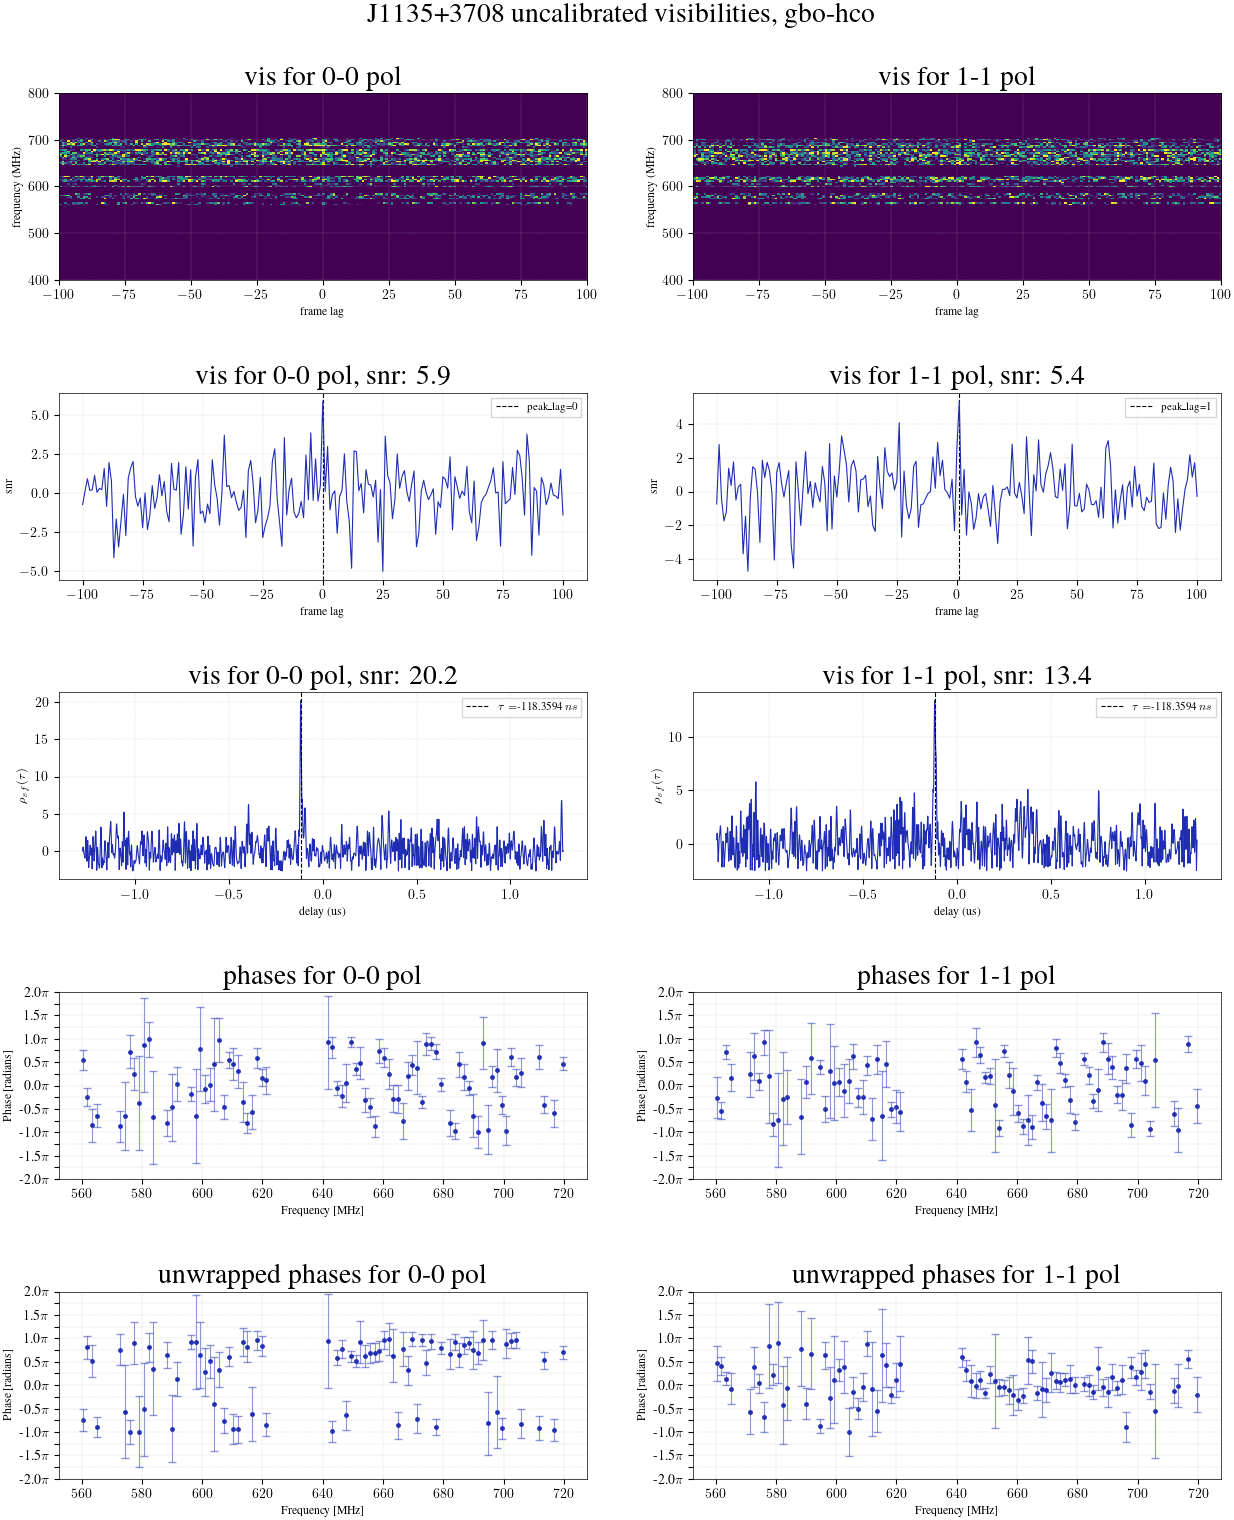

<Figure size 1200x600 with 0 Axes>

In [124]:
f=glob('/arc/projects/chime_frb/vlbi/manual_triggers/2025/05/09/20250509042648/calibrator_visibilities/*J1135+3708*')[0]
vis=VLBIVis.from_file(f)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)


In [119]:
from scipy.optimize import least_squares,curve_fit
import numpy as np
import emcee
import importlib
import astropy.units as un
from scipy.interpolate import RegularGridInterpolator
from glob import glob
from outriggers_vlbi_pipeline.vlbi_pipeline_config import gbo# as og_hco

from functools import lru_cache

#@lru_cache(maxsize=None)
#def cached_interpolant(index, theta):
#    return tau_interpolants[index](theta)[0]

from numba import jit
@jit(nopython=True)
def fast_log_likelihood(tau_meas, taus, snrs):
    lls = -((tau_meas - taus) ** 2) * snrs ** 2
    return np.sum(lls)



def log_likelihood(theta, tau_meas, tau_interpolants,snrs=1):
    """Evaluate the log-likelihood at given parameters using the interpolant."""

    # Check bounds using NumPy (much faster than looping)
    theta = np.asarray(theta)  # Ensure array

    # Vectorized interpolation: evaluate all interpolants at once
    #taus = np.array([cached_interpolant(i, tuple(theta)) for i in range(len(tau_interpolants))])
    taus = np.array([tau_interpolant(theta)[0] for tau_interpolant in tau_interpolants])

    # Vectorized log-likelihood calculation
    lls = -((tau_meas - taus) ** 2 * snrs ** 2)
    return fast_log_likelihood(tau_meas, taus, snrs)



import time

from glob import glob
import importlib
import time
import astropy.units as un
from scipy.interpolate import RegularGridInterpolator
import pandas

all_snrs=[]

tau_interpolants=[]
all_tau_meas=[]
all_tau_meas_no_iono=[]
delta_ys=[]
delta_xs=[]
files_used=[] 

used=[]
delta_ys=[]
delta_xs=[]
tecs=[]
out_files=[]


import time

tau_interpolants=[]
all_tau_meas=[]
all_tau_meas_no_iono=[]

files=glob('/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry*/grid/*J1153+8058_calibrated_to_J1135+4258*.npy')

for f in files:
    if 'gbo-hco' not in f:
        grid=np.load(f)

        gbo_xs=np.unique(grid['x_gbo'])
        gbo_ys=np.unique(grid['y_gbo'])
        gbo_zs=np.unique(grid['z_gbo'])

        hco_xs=np.unique(grid['x_hco'])
        hco_ys=np.unique(grid['y_hco'])
        hco_zs=np.unique(grid['z_hco'])

        out_taus=np.zeros(
            shape=(len(gbo_xs),len(gbo_ys),len(gbo_zs),len(hco_xs),len(hco_ys),len(hco_zs)),
            dtype=float
        )
        for i,xgbo in enumerate(gbo_xs):
            for j,ygbo in enumerate(gbo_ys):
                for k,zgbo in enumerate(gbo_zs):
                    for l,xhco in enumerate(hco_xs):
                        for m,yhco in enumerate(hco_ys):
                            for n,zhco in enumerate(hco_zs):
                                val=grid['tau'][np.where(
                                    (
                                        (
                                            (grid['x_gbo']==xgbo)&(grid['y_gbo']==ygbo)
                                        )
                                        &(grid['z_gbo']==zgbo)
                                    )
                                    &
                                    (
                                        (
                                            (grid['x_hco']==xhco)&(grid['y_hco']==yhco)
                                        )
                                        &(grid['z_hco']==zhco)
                                    )
                                )][0]
                                out_taus[i,j,k,l,m,n]=val

        tau_meas=grid['tau_meas'][0]
        interpolant=RegularGridInterpolator((gbo_xs,gbo_ys,gbo_zs,hco_xs,hco_ys,hco_zs),out_taus)
        tau_interpolants.append(interpolant)
        all_tau_meas.append(tau_meas)
        all_tau_meas_no_iono.append(grid['tau_meas_no_iono'][0])

print(len(all_tau_meas))
all_tau_meas=np.array(all_tau_meas)
tau_interpolants=np.array(tau_interpolants)



N=5
gbo_xs=np.linspace(np.min(gbo_xs),np.max(gbo_xs),N)
gbo_ys=np.linspace(np.min(gbo_ys),np.max(gbo_ys),N)
gbo_zs=np.linspace(np.min(gbo_zs),np.max(gbo_zs),N)


hco_xs=np.linspace(np.min(hco_xs),np.max(hco_xs),N)
hco_ys=np.linspace(np.min(hco_ys),np.max(hco_ys),N)
hco_zs=np.linspace(np.min(hco_zs),np.max(hco_zs),N)


out_likelihoods=np.zeros(
    shape=(len(gbo_xs),len(gbo_ys),len(gbo_zs),len(hco_xs),len(hco_ys),len(hco_zs)),
    dtype=float
)
for i,xgbo in enumerate(gbo_xs):
    print(i)
    for j,ygbo in enumerate(gbo_ys):
        for k,zgbo in enumerate(gbo_zs):
            for l,xhco in enumerate(hco_xs):
                for m,yhco in enumerate(hco_ys):
                    for n,zhco in enumerate(hco_zs):
                        val=log_likelihood(np.array([xgbo,ygbo,zgbo,xhco,yhco,zhco]), all_tau_meas, tau_interpolants,snrs=1)
                        out_likelihoods[i,j,k,l,m,n]=val


2
0
1
2
3
4


[2025-05-19 03:05:21,361] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,402] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,429] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,469] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,495] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,521] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,563] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,590] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,617] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,645] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,689] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,719] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,748] WARNING Too few points to create valid contours
[2025-05-19 03:05:21,780] WARNING Too 

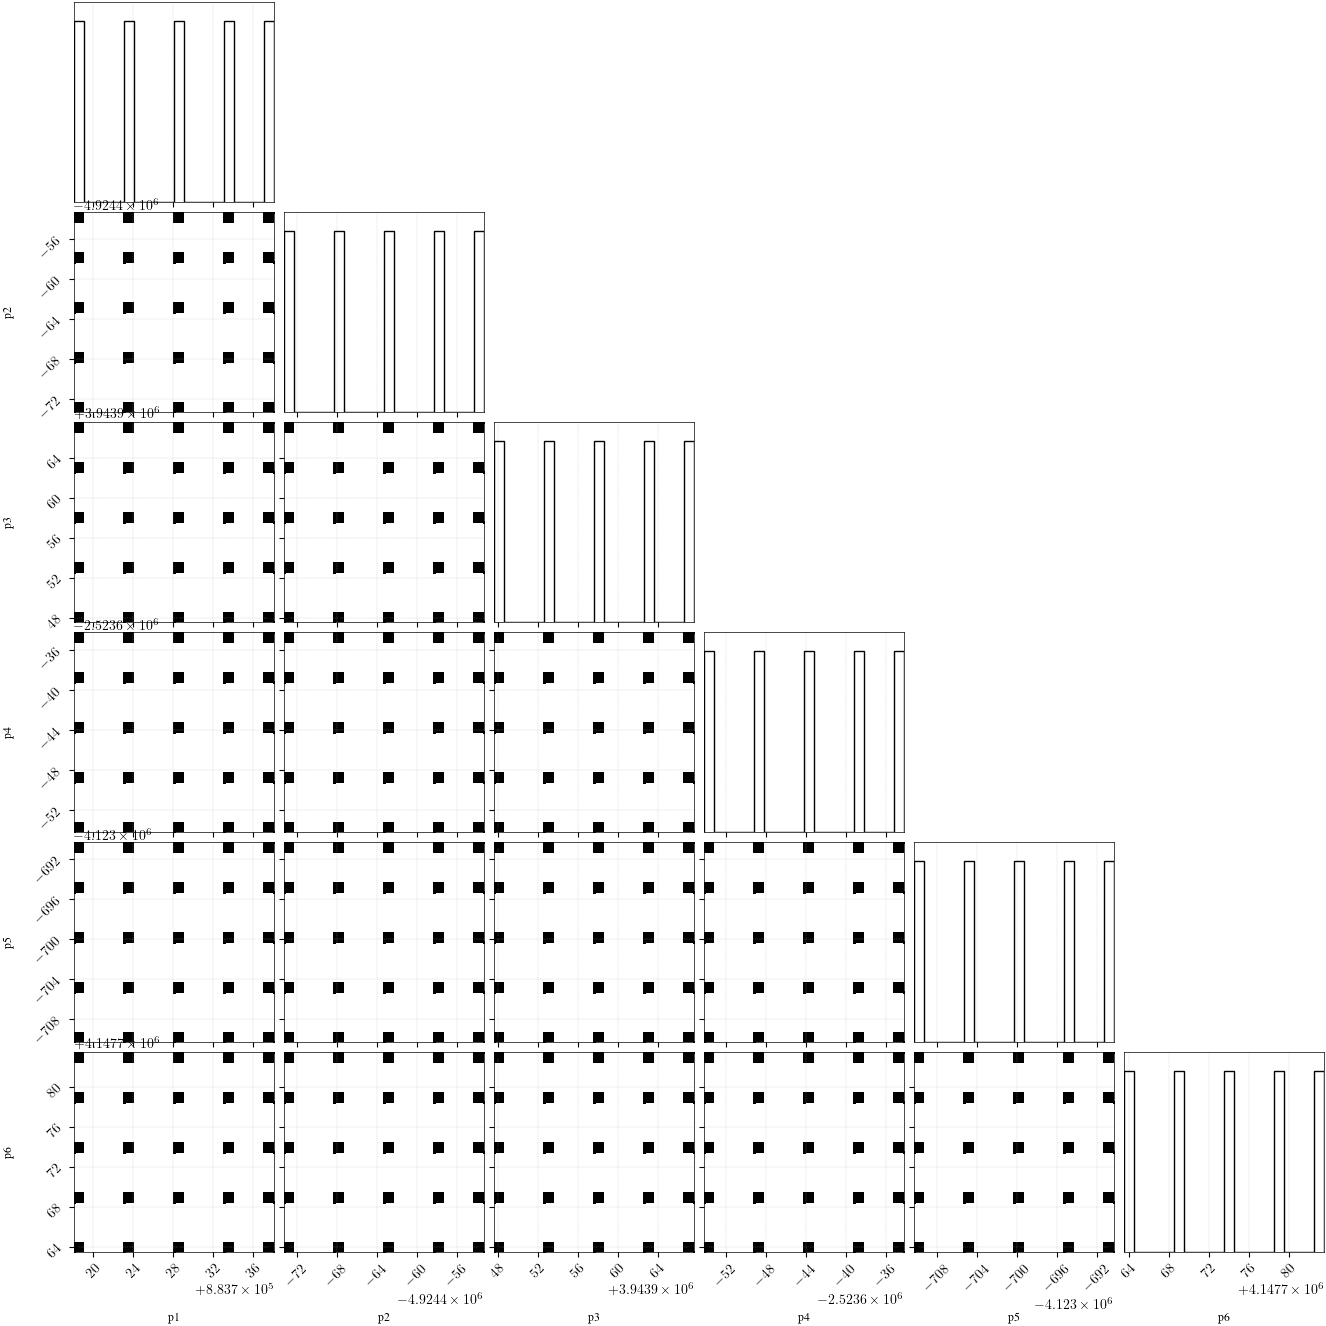

In [120]:
grid = np.meshgrid(gbo_xs, gbo_ys, gbo_zs, hco_xs, hco_ys, hco_zs, indexing='ij')
# 4. Flatten everything
flat_params = [g.ravel() for g in grid]  # List of 6 arrays of shape (N1*N2*...*N6,)
flat_likelihood = out_likelihoods.ravel()

# 5. Stack parameters into samples shape (N_samples, 6)
samples = np.vstack(flat_params).T

# 7. Corner plot!
figure = corner.corner(samples, labels=["p1", "p2", "p3", "p4", "p5", "p6"])


In [130]:

tel1_name='chime'
tel2_name='hco'
tel2=tel2_name
#tag='M4_true_pos_fit_all'

#tel2='hco'
#tag=f'A22_manual_fit_all'
tag=f'M12_OVP_astrometry'
df=pandas.read_csv(f'/arc/home/shiona/scripts/manual_triggers_{tag}_{tel1_name}_{tel2_name}.csv') #/arc/home/shiona/scripts/hco_test2_baseline_offset_fit_data2.csv')
df['tau_xx']*1e3

0   -3.15
1   -1.51
2   -1.25
3   -0.11
Name: tau_xx, dtype: float64

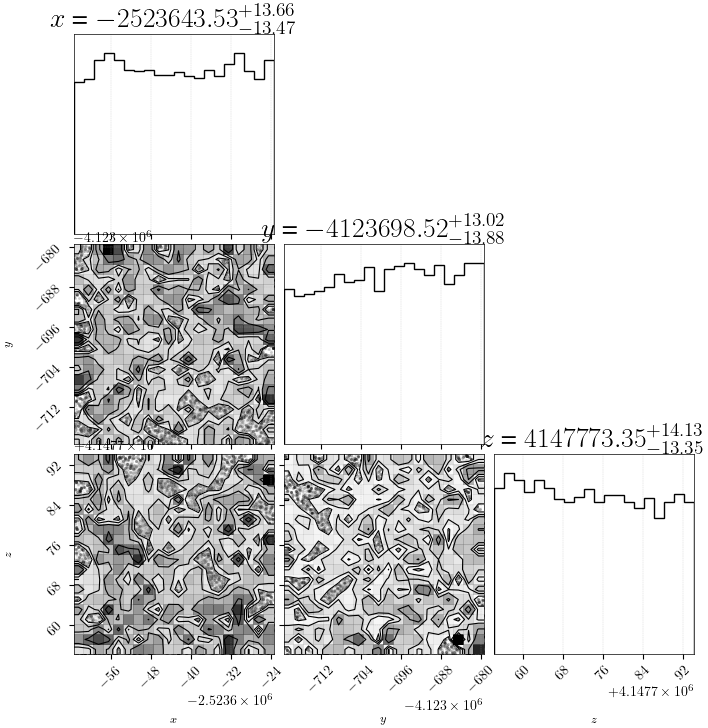

In [132]:
import matplotlib.pyplot as plt
from outriggers_vlbi_pipeline.vlbi_pipeline_config import gbo,hco
samples=np.load('M12_OVP_astrometry_hco_single.npy')
import corner
#corner.corner(samples, labels=["x", "y", "z"], truths=best_fit)
#plt.show()

import corner
import matplotlib.pyplot as plt

# Assuming 'samples' is your (n_samples, n_dim) MCMC output
figure = corner.corner(samples, labels=[r"$x$", r"$y$", r"$z$"], 
                        show_titles=True, title_fmt=".2f")

plt.show()


In [ ]:
        grid_out=np.array(new_out_data,dtype=[('x_gbo', 'float64'), ('y_gbo', 'float64'), ('z_gbo', 'float64'),
                                              ('x_hco', 'float64'), ('y_hco', 'float64'), ('z_hco', 'float64'),
                                              ('tau','float64'),('tau_meas','float64'),('tau_meas_no_iono','float64'),('snr_xx','float64'),('incoh_snr_xx','float64')])
        np.save(file, grid_out) 

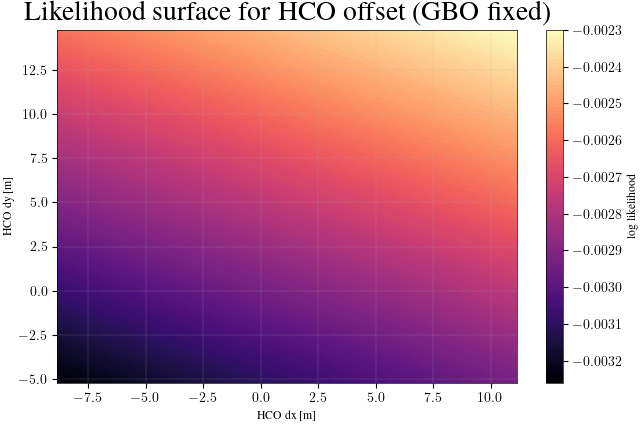

In [112]:
import matplotlib.pyplot as plt
from outriggers_vlbi_pipeline.vlbi_pipeline_config import hco,gbo #.pyplot as plt
f='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry_gbo-hco/grid/20250418054922_grid_M12_OVP_astrometry_gbo-hco_J1145+695A_calibrated_to_J1135+4258.npy'
#f='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry_gbo-hco/grid/20250418054922_grid_M12_OVP_astrometry_gbo-hco_J1153+8058_calibrated_to_J1135+4258.npy'
f='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry_gbo-hco/grid/20250418054922_grid_M12_OVP_astrometry_gbo-hco_J1132+5100_calibrated_to_J1135+4258.npy'
data=np.load(f)

dx1_out=data['x_gbo']-gbo.x.value
dy1_out=data['y_gbo']-gbo.y.value
dz1_out=data['z_gbo']-gbo.z.value

dx2_out=data['x_hco']-hco.x.value
dy2_out=data['y_hco']-hco.y.value
dz2_out=data['z_hco']-hco.z.value



dx2_out=data['x_gbo']-gbo.x.value
dy2_out=data['y_gbo']-gbo.y.value
dz2_out=data['z_gbo']-gbo.z.value

dx1_out=data['x_hco']-hco.x.value
dy1_out=data['y_hco']-hco.y.value
dz1_out=data['z_hco']-hco.z.value



liks_out=-(data['tau']-data['tau_meas'])**2


# Fix GBO offsets, only show HCO offset likelihood
mask = (dx1_out == np.median(dx1_out)) & (dy1_out == np.median(dy1_out)) & (dz1_out == np.median(dz1_out)) & (dz2_out == np.median(dz2_out))  # Fix GBO offset
idx=np.nanargmax(liks_out)
#mask = (dx1_out == np.median(dx1_out)) & (dy1_out == np.median(dy1_out)) & (dz1_out == np.median(dz1_out)) & (dz2_out == np.median(dz2_out))  # Fix GBO offset
mask = (dx1_out == dx1_out[idx]) & (dy1_out == dy1_out[idx]) & (dz1_out == dz1_out[idx]) & (dz2_out == dz2_out[idx])  # Fix GBO offset

x = dx2_out[mask]
y = dy2_out[mask]
likelihood = liks_out[mask]

plt.tricontourf(x, y, likelihood, levels=100, cmap='magma')
plt.xlabel('HCO dx [m]')
plt.ylabel('HCO dy [m]')
plt.title('Likelihood surface for HCO offset (GBO fixed)')
plt.colorbar(label='log likelihood')
plt.grid(True)
plt.show()




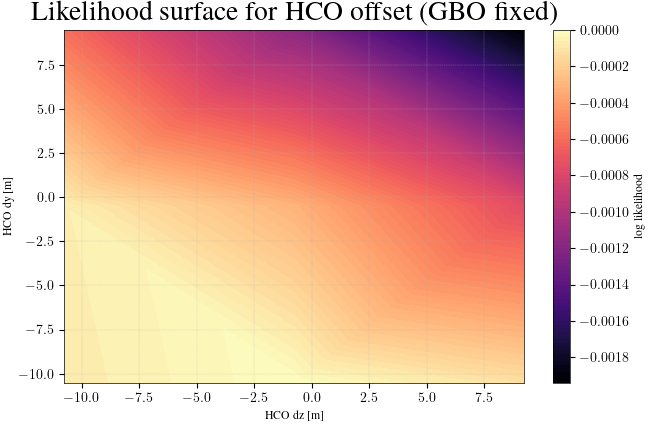

In [103]:
import matplotlib.pyplot as plt
f='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry_gbo-hco/grid/20250418054922_grid_M12_OVP_astrometry_gbo-hco_J1153+8058_calibrated_to_J1135+4258.npy'
data=np.load(f)
dx1_out=data['x_gbo']
dy1_out=data['y_gbo']
dz1_out=data['z_gbo']

dx2_out=data['x_hco']-hco.x.value
dy2_out=data['y_hco']-hco.y.value
dz2_out=data['z_hco']-hco.z.value

liks_out=-(data['tau']-data['tau_meas'])**2


# Fix GBO offsets, only show HCO offset likelihood
idx=np.nanargmax(liks_out)
#mask = (dx1_out == np.median(dx1_out)) & (dy1_out == np.median(dy1_out)) & (dz1_out == np.median(dz1_out)) & (dz2_out == np.median(dz2_out))  # Fix GBO offset
mask = (dx1_out == dx1_out[idx]) & (dy1_out == dy1_out[idx]) & (dz1_out == dz1_out[idx]) & (dz2_out == dz2_out[idx])  # Fix GBO offset
#mask = (dx1_out == dx1_out[idx]) & (dy1_out == dy1_out[idx]) & (dz1_out == dz1_out[idx]) & (dx2_out == dx2_out[idx])  # Fix GBO offset

x = dx2_out[mask]
z = dz2_out[mask]
y = dy2_out[mask]
likelihood = liks_out[mask]

plt.tricontourf(x, y, likelihood, levels=100, cmap='magma')
#plt.tricontourf(z, y, likelihood, levels=100, cmap='magma')
plt.xlabel('HCO dz [m]')
plt.ylabel('HCO dy [m]')
plt.title('Likelihood surface for HCO offset (GBO fixed)')
plt.colorbar(label='log likelihood')
plt.grid(True)
plt.show()



702

In [ ]:
valid_files['gbo-hco']=['/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/J1145+6958_calibrated_to_J1135+4258_vis.h5']


valid_files['chime-hco']=['/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1137+3950_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1138+2524_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5025_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5638_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5743_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1131+4514_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J2344+8226_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1128+5925_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+5912_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+3815_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+5912_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4657_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+4032_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+3803_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J113053.2+381518_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112553.7+261019_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J234403.7+822640_calibrated_to_J112740.1+565014_vis.h5',
                          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1124+1919_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+5100_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1145+6958_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1126+3345_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5638_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J115312.4+805829_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112813.3+592514_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5025_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1127+5743_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+6324_calibrated_to_J112740.1+565014_vis.h5']

valid_files['chime-gbo']=['/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1137+3950_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1138+2524_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5025_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1145+6958_vis.h5',
                          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5638_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5743_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1131+4514_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J2344+8226_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1128+5925_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/J1140+5912_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1130+3815_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+5912_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1140+4657_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+4032_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1139+3803_calibrated_to_J1135+4258_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1145+6958_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J113053.2+381518_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112553.7+261019_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J234403.7+822640_calibrated_to_J112740.1+565014_vis.h5',
                          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+5100_calibrated_to_J112740.1+565014_vis.h5',
                          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1145+6958_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1124+1919_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1126+3345_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5638_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J115312.4+805829_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J112813.3+592514_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1129+5025_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1127+5743_calibrated_to_J112740.1+565014_vis.h5',
                         '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/J1132+6324_calibrated_to_J112740.1+565014_vis.h5']


i=35
f=glob('/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250417054519/*')[i]
print(f)
vis=VLBIVis.from_file(f)
plot_visibility_diagnostics(vis,close=False,flag_rfi=False)


In [ ]:
new_add=[
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1137+3950_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135-0021_calibrated_to_J1145+6958_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1145+6958_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5638_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5743_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1131+4514_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+6324_calibrated_to_J1135+4258_vis.h5',
    '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J2344+8226_calibrated_to_J1135+4258_vis.h5'
]
    

In [30]:
#vis=VLBIVis.from_file('/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5650_calibrated_to_J1145+6958_vis.h5')
for key in vis['chime-hco']['vis'].attrs.keys():
    if 'tau' in key or 'tec' in key:
        print(vis['chime-hco']['vis'].attrs[key])


[ 0.00253 -0.00165]
[0.00669 0.0067 ]
[-1.1 -2.2]


In [49]:
new_add2=['/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5',
          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5',
          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5',
          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5',
          '/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1127+5650_calibrated_to_J1145+6958_vis.h5',
]

tel1_name='gbo'
tel2_name='hco'
baseline=tel1_name + '-' + tel2_name

tag=f'M12_OVP_astrometry'
out_file=f'/arc/home/shiona/scripts/manual_triggers_{tag}_{tel1_name}_{tel2_name}.csv'
print(out_file)


all_vis=[]
for i,file in enumerate(new_add2):
    if i%10==0:
        print(i)
    try:
        vis=VLBIVis.from_file(file)
        vis.attrs.filename=file
        all_vis.append(vis)
    except Exception as e:
        print(e)

import pandas as pd
import importlib
out_dicts=[]
for i,vis in enumerate(all_vis):
    try:
        out_dict=extract_info(vis,baseline=baseline,fmin=800,fmax=800)
        out_dict['filename']=vis.attrs.filename
        out_dicts.append(out_dict)
    except Exception as e:
        print(e)
df = pd.DataFrame(out_dicts)

import beam_model
xs=[]
ys=[]
for i in range(len(df)):
    ctime=df['ctime'][i]
    ra=df['calibrator_ra'][i]#.ra.deg[0]
    dec=df['calibrator_dec'][i]#.dec.deg[0]
    x,y=beam_model.utils.get_position_from_equatorial(ra, dec,ctime)
    xs.append(x)
    ys.append(y)
df['x_cal']=xs
df['y_cal']=ys

xs=[]
ys=[]
for i in range(len(df)):
    ctime=df['ctime'][i]
    ra=df['ra'][i]#.ra.deg[0]
    dec=df['dec'][i]#.dec.deg[0]
    x,y=beam_model.utils.get_position_from_equatorial(ra, dec,ctime)
    xs.append(x)
    ys.append(y)
df['x_tar']=xs
df['y_tar']=ys

df['delta_x']=df['x_tar']-df['x_cal']
df['delta_y']=df['y_tar']-df['y_cal']


print(out_file)

df.to_csv(out_file)

/arc/home/shiona/scripts/manual_triggers_M12_OVP_astrometry_gbo_hco.csv
0
Applying TEC correction (1.0000000000000142 tecu)
Applying TEC correction (-1.0000000000000142 tecu)
Applying TEC correction (1.0000000000000142 tecu)
Applying TEC correction (-1.0000000000000142 tecu)
Applying TEC correction (0.8000000000000114 tecu)
Applying TEC correction (-0.8000000000000114 tecu)
Applying TEC correction (0.8000000000000114 tecu)
Applying TEC correction (-0.8000000000000114 tecu)
Applying TEC correction (1.0000000000000142 tecu)
Applying TEC correction (-1.0000000000000142 tecu)
Applying TEC correction (1.0000000000000142 tecu)
Applying TEC correction (-1.0000000000000142 tecu)
Applying TEC correction (-0.10000000000000142 tecu)
Applying TEC correction (0.10000000000000142 tecu)
Applying TEC correction (-0.10000000000000142 tecu)
Applying TEC correction (0.10000000000000142 tecu)
/arc/home/shiona/scripts/manual_triggers_M12_OVP_astrometry_gbo_hco.csv


In [ ]:
import coda
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities,fringefit

tec_grid=np.arange(-20,20,.1)
for file in new_add2:
    print(file)
    vis=VLBIVis.from_file(file)
    baselines=['chime-gbo','chime-hco']#,'gbo-hco']
    for baseline in baselines:
        fringefit(vis[baseline],tec_grid=tec_grid)
    print(file)
    vis.save(file)

In [22]:
import coda
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities,fringefit

tec_grid=np.arange(-20,20,.1)
for file in new_add2:
    print(file)
    vis=VLBIVis.from_file(file)
    baselines=['gbo-hco']
    for baseline in baselines:
        tecs0=vis['chime-hco']['vis'].attrs['tecs'][0]-vis['chime-gbo']['vis'].attrs['tecs'][0]
        tec_grid=np.array([tecs0])
        del vis['gbo-hco']['vis'].attrs['taus']
        del vis['gbo-hco']['vis'].attrs['tecs']
        fringefit(vis[baseline],tec_grid=tec_grid,grid=np.arange(-0.1,0.1,1e-5))
    print(file)
    vis.save(file)

/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:51:40,521] INFO Evaluating probability chunk # 0 out of 2 iterations
[2025-05-19 00:51:40,700] INFO Evaluating probability chunk # 1 out of 2 iterations


-0.068125


[2025-05-19 00:51:40,910] INFO best tec fit: 1.0000000000000142
[2025-05-19 00:51:40,920] INFO Evaluating probability chunk # 0 out of 2 iterations
[2025-05-19 00:51:41,106] INFO Evaluating probability chunk # 1 out of 2 iterations


-0.06420000000001388
-0.0696875


[2025-05-19 00:51:41,308] INFO best tec fit: 1.0000000000000142


-0.06335000000001421
/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5
/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:51:42,144] INFO Evaluating probability chunk # 0 out of 2 iterations
[2025-05-19 00:51:42,314] INFO Evaluating probability chunk # 1 out of 2 iterations


-0.067890625


[2025-05-19 00:51:42,604] INFO best tec fit: 0.8000000000000114
[2025-05-19 00:51:42,609] INFO Evaluating probability chunk # 0 out of 2 iterations
[2025-05-19 00:51:42,798] INFO Evaluating probability chunk # 1 out of 2 iterations


-0.06445000000001379
-0.011875


[2025-05-19 00:51:43,004] INFO best tec fit: 0.8000000000000114


-0.06510000000001354
/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:51:43,616] INFO Evaluating probability chunk # 0 out of 2 iterations


/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5
-0.07187500000000001


[2025-05-19 00:51:43,799] INFO Evaluating probability chunk # 1 out of 2 iterations
[2025-05-19 00:51:44,007] INFO best tec fit: 1.0000000000000142
[2025-05-19 00:51:44,102] INFO Evaluating probability chunk # 0 out of 2 iterations
[2025-05-19 00:51:44,300] INFO Evaluating probability chunk # 1 out of 2 iterations


-0.06875000000001212
-0.069140625


[2025-05-19 00:51:44,598] INFO best tec fit: 1.0000000000000142


-0.06792000000001244
/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:51:45,110] INFO Evaluating probability chunk # 0 out of 2 iterations


/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5
-0.06343750000000001


[2025-05-19 00:51:45,304] INFO Evaluating probability chunk # 1 out of 2 iterations
[2025-05-19 00:51:45,599] INFO best tec fit: -0.10000000000000142
[2025-05-19 00:51:45,606] INFO Evaluating probability chunk # 0 out of 2 iterations


-0.06343000000001418
-0.06421875


[2025-05-19 00:51:45,808] INFO Evaluating probability chunk # 1 out of 2 iterations
[2025-05-19 00:51:46,004] INFO best tec fit: -0.10000000000000142


-0.06400000000001396
/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1132+5100_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:47:29,532] INFO adding vis error in vlbivis


[[  -1.25     1029.140625]
 [-424.140625   -1.484375]]
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)


array([<Axes: title={'center': ' vis for 0-0 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 1-1 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 30.2'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 16.6'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 54.0'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 38.0'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': ' phases for 1-1 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped 

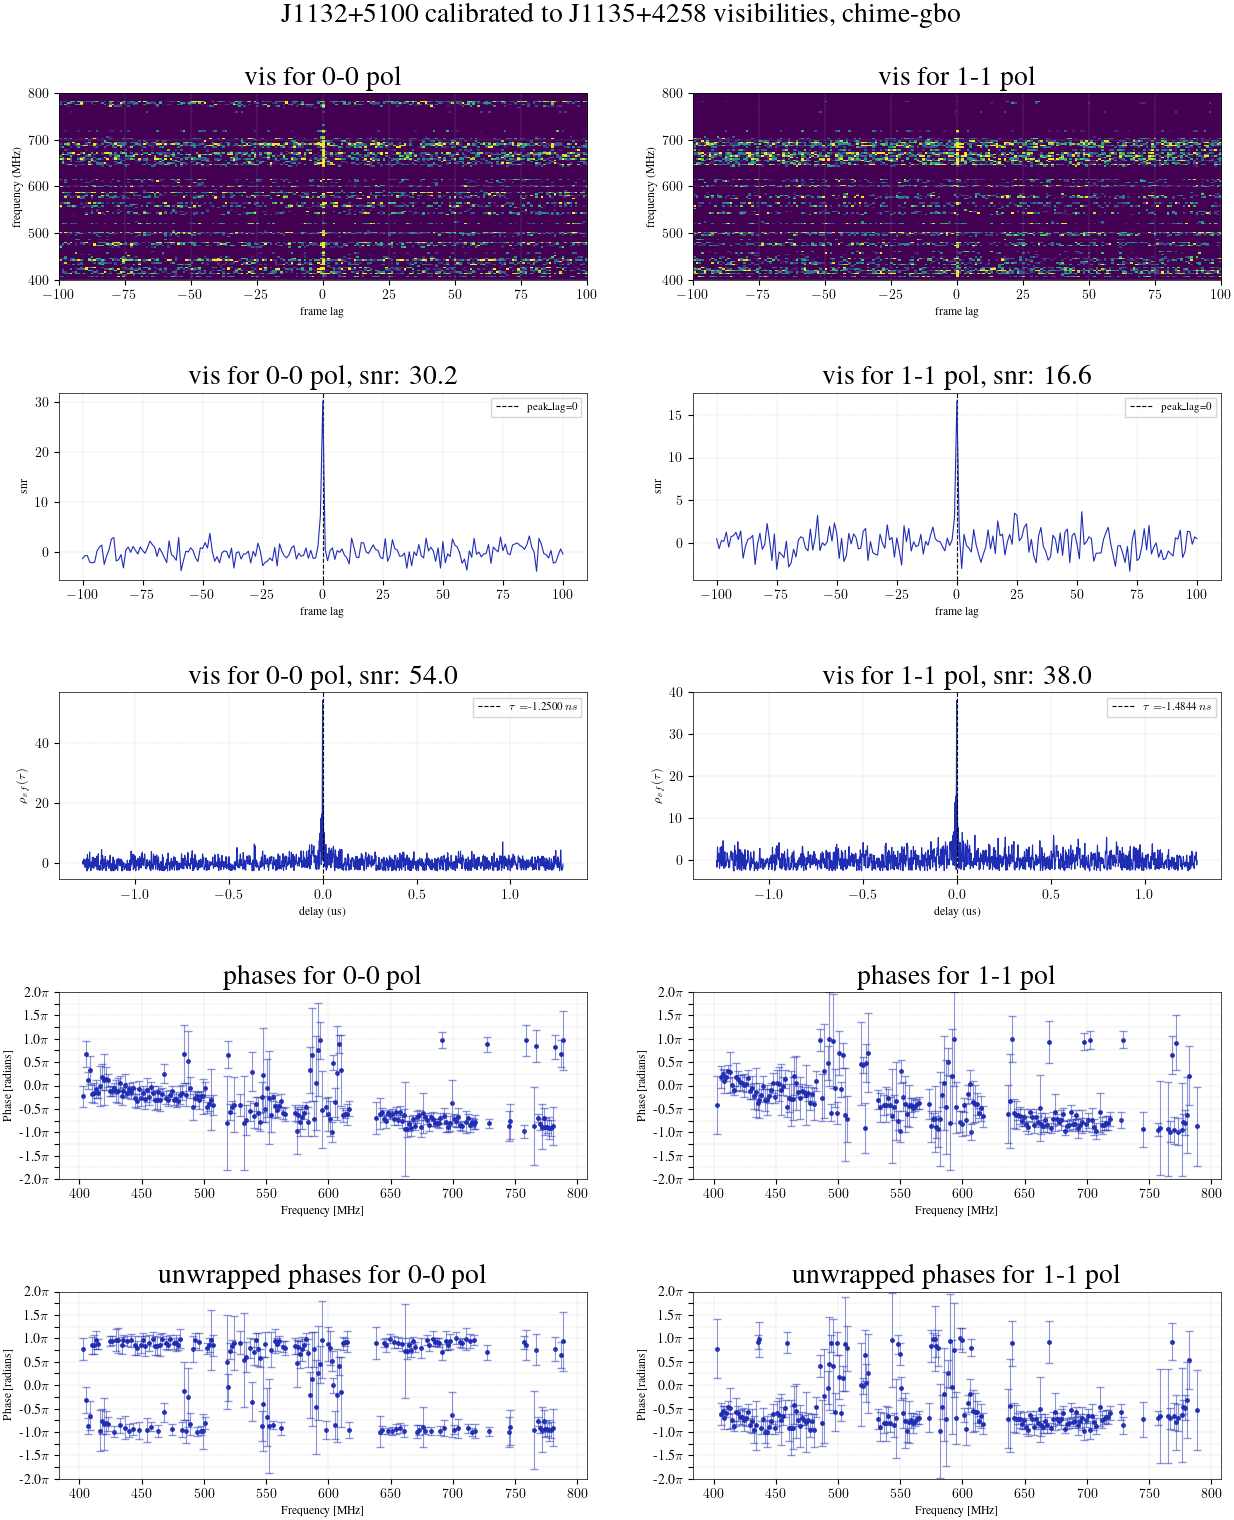

<Figure size 1200x600 with 0 Axes>

In [7]:
bl='chime-gbo'
coh_tau,coh_snrs=np.array(coda.analysis.delay.extract_subframe_delay(vis[bl]))
print(coh_tau*1e3)
plot_visibility_diagnostics(vis,close=False,baseline_name=bl,fscrunch=4)


In [23]:
i=1
f=new_add2[i]
print(f)
vis=VLBIVis.from_file(f)
bl='chime-gbo'
print(vis[bl]['vis'].attrs['taus']*1e3)
#plot_visibility_diagnostics(vis,close=False,baseline_name=bl,fscrunch=4)


/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1153+8058_calibrated_to_J1135+4258_vis.h5
[1.23 0.32]


In [24]:
bl='gbo-hco'
print(vis[bl]['vis'].attrs['taus']*1e3)


[-64.45 -65.1 ]


[2025-05-19 00:52:03,609] INFO adding vis error in vlbivis


Applying TEC correction (0.8000000000000114 tecu)
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


array([<Axes: title={'center': ' vis for 0-0 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 1-1 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 6.2'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 3.9'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 13.7'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 5.3'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': ' phases for 1-1 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  ph

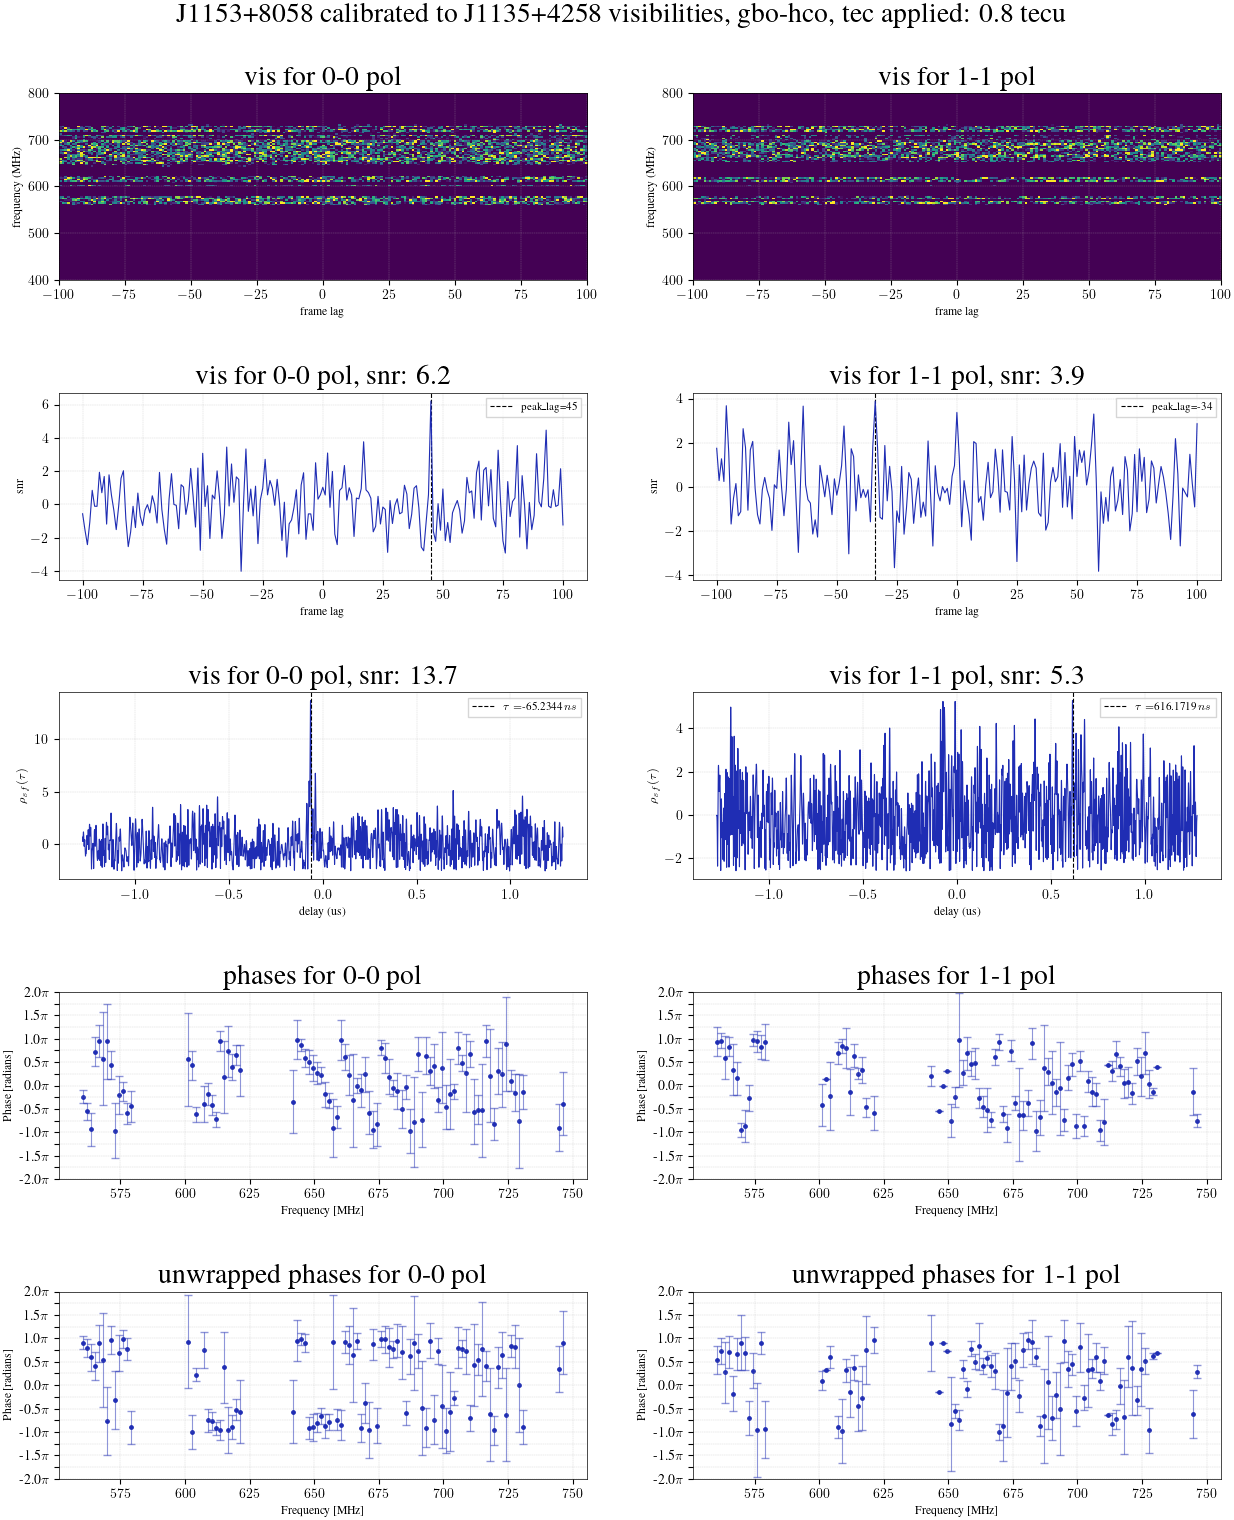

<Figure size 1200x600 with 0 Axes>

In [25]:
vis=VLBIVis.from_file(f)

tecs0=vis['gbo-hco']['vis'].attrs['tecs'][0]
coda.analysis.iono.remove_tec(vis['gbo-hco'],delta_tec=tecs0,write=True)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)


In [63]:
import pandas
f='/arc/home/shiona/scripts/manual_triggers_M12_OVP_astrometry_chime_gbo.csv'
df=pandas.read_csv(f)
x='J1145+6958'
df[df['name']==x]['tau_xx']*1e3




2   -1.82
Name: tau_xx, dtype: float64

[2025-05-19 01:04:21,234] INFO adding vis error in vlbivis


/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+6958_calibrated_to_J1135+4258_vis.h5
Applying TEC correction (1.0000000000002984 tecu)
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
[-1.82 -0.95]


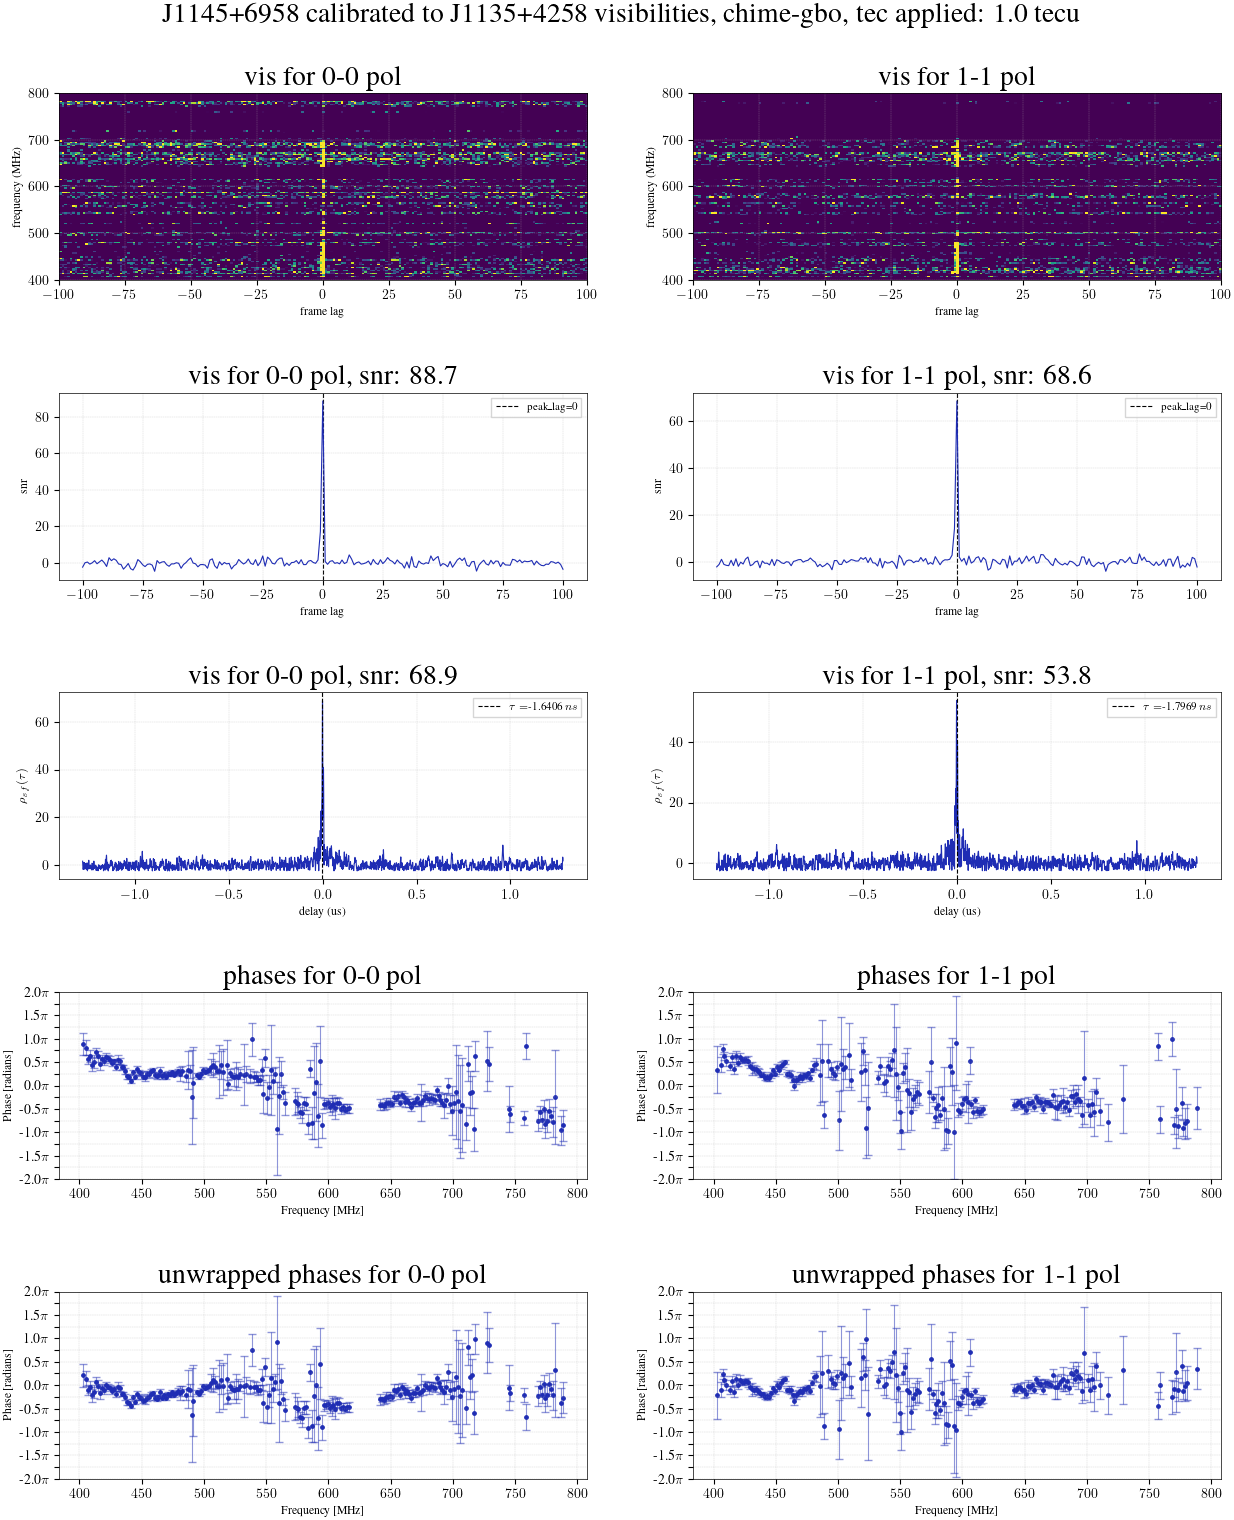

<Figure size 1200x600 with 0 Axes>

In [62]:
i=2
f=new_add2[i]
print(f)
vis=VLBIVis.from_file(f)


bl='chime-gbo'

tecs0=vis[bl]['vis'].attrs['tecs'][0]
coda.analysis.iono.remove_tec(vis[bl],delta_tec=tecs0,write=True)
plot_visibility_diagnostics(vis,close=False,baseline_name=bl,fscrunch=4)
print(vis[bl]['vis'].attrs['taus']*1e3)


/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1145+695A_calibrated_to_J1135+4258_vis.h5


[2025-05-19 00:49:33,821] INFO adding vis error in vlbivis


Applying TEC correction (1.0000000000000142 tecu)
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


[2025-05-19 00:49:34,552] INFO adding vis error in vlbivis


Applying TEC correction (-1.0000000000000142 tecu)
Applying TEC correction (-1.0000000000000142 tecu)
vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in
[2. 2.]
[1.  1.4]
[1. 1.]
[1.  0.6]


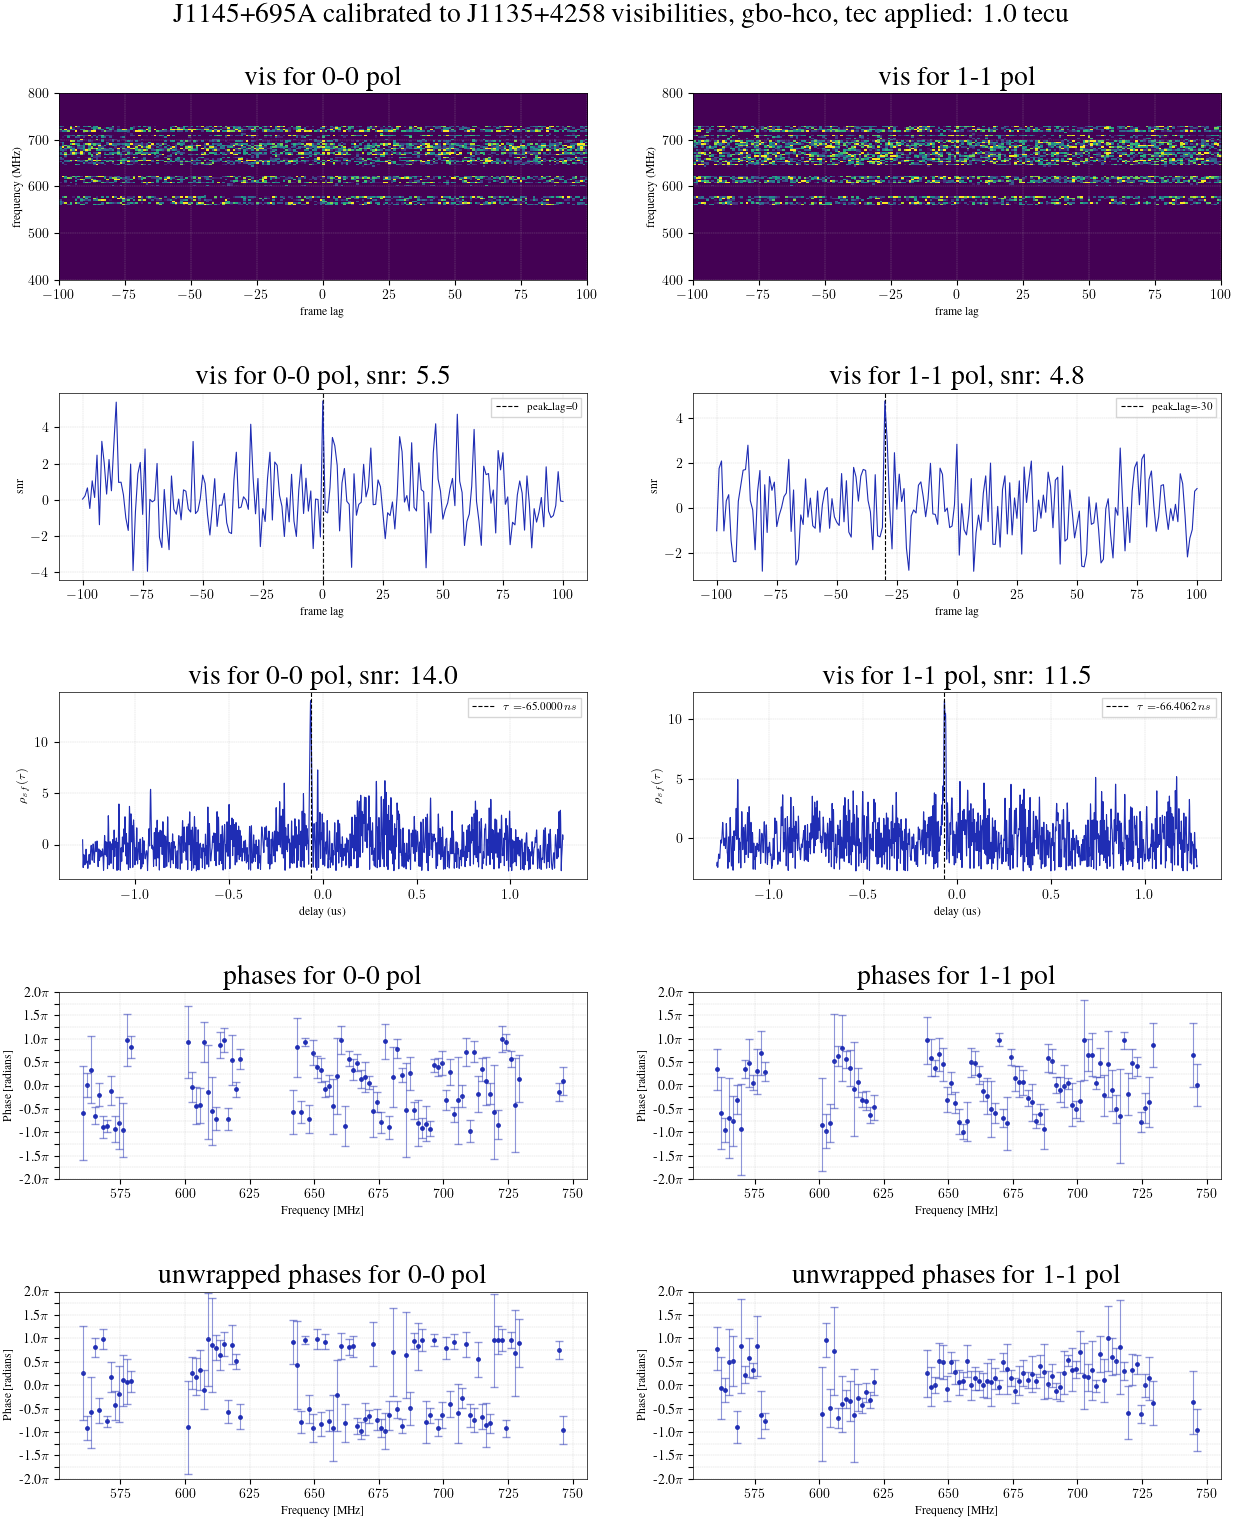

<Figure size 1200x600 with 0 Axes>

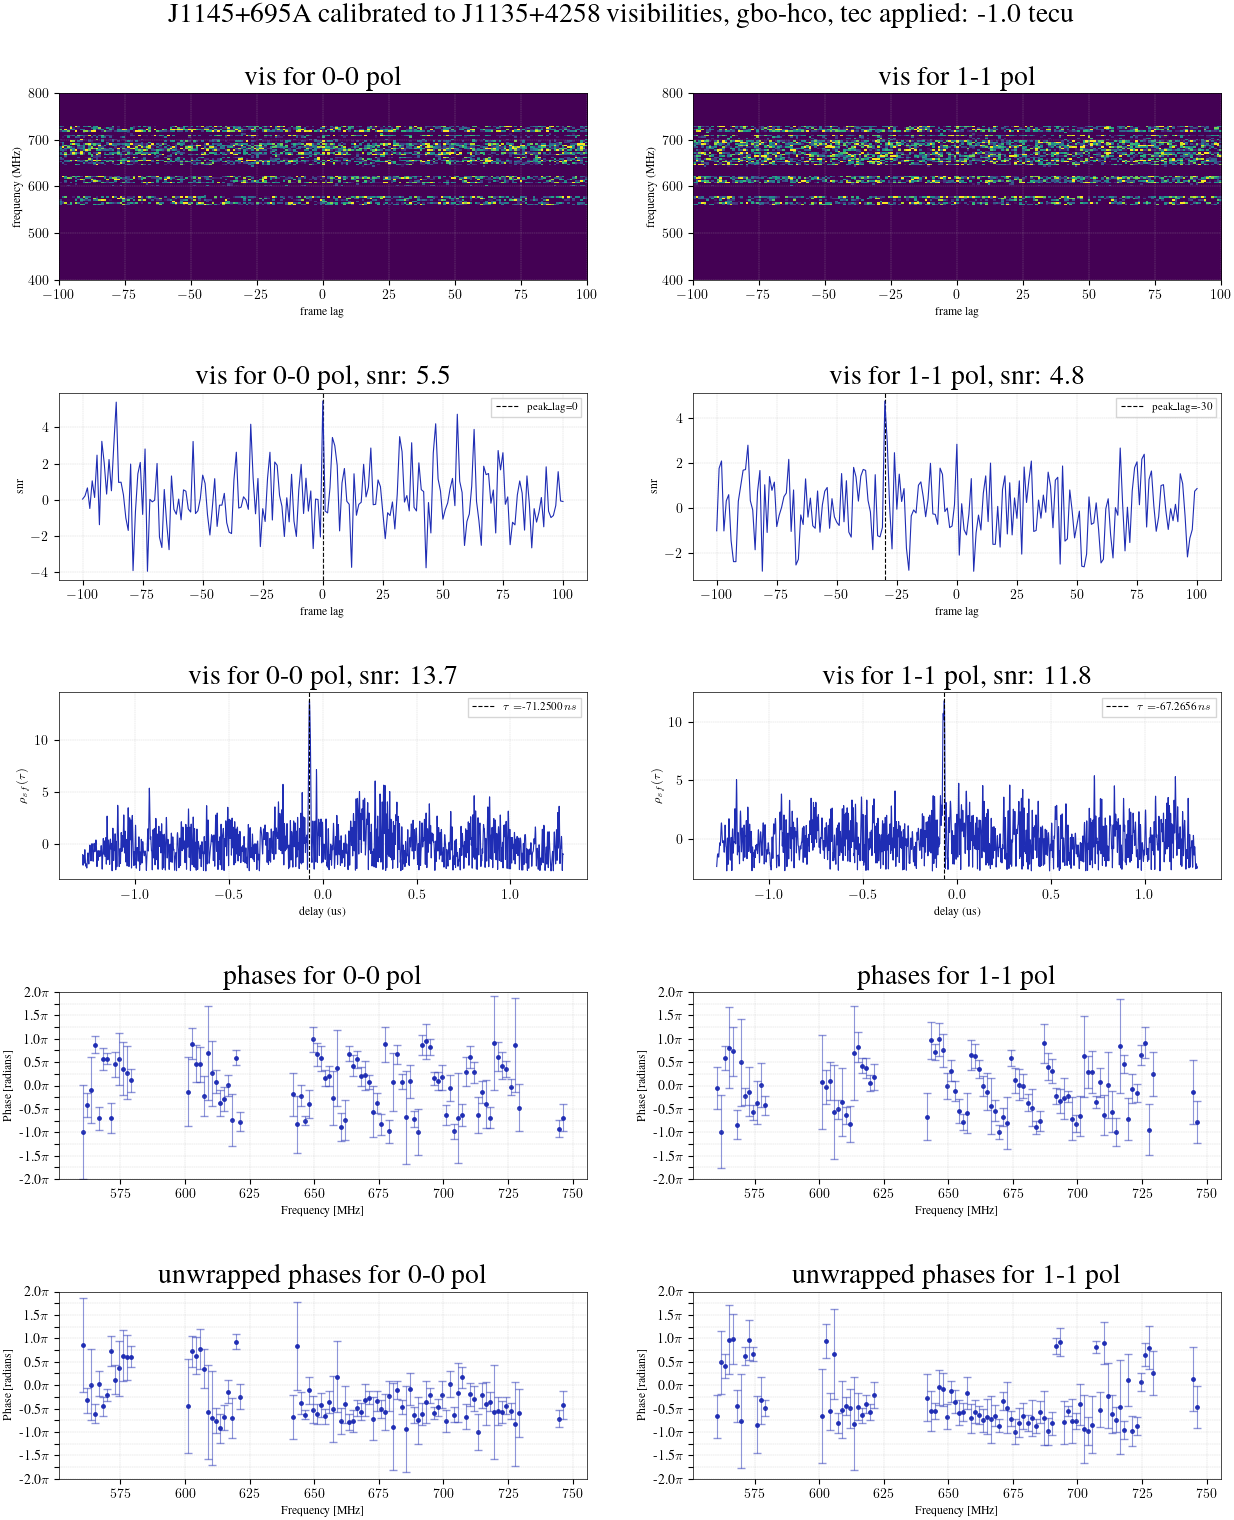

<Figure size 1200x600 with 0 Axes>

In [17]:
i=0
f=new_add2[i]
print(f)
vis=VLBIVis.from_file(f)

tecs0=vis['gbo-hco']['vis'].attrs['tecs'][0]
#plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)

coda.analysis.iono.remove_tec(vis['gbo-hco'],delta_tec=tecs0,write=True)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)

coda.analysis.iono.undo_tec(vis['gbo-hco'],verbose=True)
tecs0=-tecs0
coda.analysis.iono.remove_tec(vis['gbo-hco'],delta_tec=tecs0,write=True)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)

print(vis['chime-hco']['vis'].attrs['tecs'])
print(vis['chime-gbo']['vis'].attrs['tecs'])
print(vis['gbo-hco']['vis'].attrs['tecs'])
print(vis['chime-hco']['vis'].attrs['tecs']-vis['chime-gbo']['vis'].attrs['tecs'])

In [22]:
baselines=['chime-gbo','chime-hco','gbo-hco']
for baseline in baselines:
    if 'tecs' not in vis[baseline]['vis'].attrs.keys():
        print(baseline)

In [ ]:
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities,fringefit
fringefit(vis[f'chime-{tel}'],tec_grid=tec_grid)


In [ ]:

f='/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1135+3708_calibrated_to_J1145+6958_vis.h5'
vis=VLBIVis.from_file(f)

mask=np.where((vis.freqs<560)&(vis.freqs>400))
vis['gbo-hco']['vis'][mask]=0.0
mask=np.where((vis.freqs>720))
vis['gbo-hco']['vis'][mask]=0.0
get_optimal_rfi_mask(vis['gbo-hco'], write=True, sub_integration_scan=0)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)


In [ ]:
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-hco',fscrunch=4)
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-gbo',fscrunch=4)

/arc/projects/chime_frb/vlbi/manual_triggers/2025/05/09/20250509042648/calibrator_visibilities/20250509042648_J1139+5300_vis.h5


[2025-05-19 13:37:12,776] WARNING Trying to undo rfi mask but unmasked visibilities not found 


4.2965736


[2025-05-19 13:37:28,160] INFO Applying channel mask. Saving mask under channel_mask, and saving unmasked visibilities under vis_channel_unmasked.
[2025-05-19 13:37:28,165] INFO adding vis error in vlbivis


4.827469
writing vis_error to container


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:644: RuntimeWarning: invalid value encountered in divide
  vis_to_plot = vis_to_plot / np.nanstd(vis_to_plot, axis=-1)[...,np.newaxis] #normalize along lag axis
/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: invalid value encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 13:37:28,502] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


/arc/home/shiona/outriggers_vlbi_pipeline/src/outriggers_vlbi_pipeline/diagnostic_plots.py:919: RuntimeWarning: divide by zero encountered in divide
  phase_err=np.sqrt(_scrunch(vis_err**2,mean=False,tscrunch=1,fscrunch=fscrunch))/np.abs(vis_to_plot) #(nfreq,npol,npol)
[2025-05-19 13:37:28,834] INFO adding vis error in vlbivis


vis_error already exists in VLBIVis container; will not be overwriten unless overwrite=True is passed in


array([<Axes: title={'center': ' vis for 0-0 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 1-1 pol'}, xlabel='frame lag', ylabel='frequency (MHz)'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 23.0'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 12.8'}, xlabel='frame lag', ylabel='snr'>,
       <Axes: title={'center': ' vis for 0-0 pol, snr: 24.1'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' vis for 1-1 pol, snr: 20.9'}, xlabel='delay (us)', ylabel='$\\rho_{sf}(\\tau)$'>,
       <Axes: title={'center': ' phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': ' phases for 1-1 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped  phases for 0-0 pol'}, xlabel='Frequency [MHz]', ylabel='Phase [radians]'>,
       <Axes: title={'center': 'unwrapped 

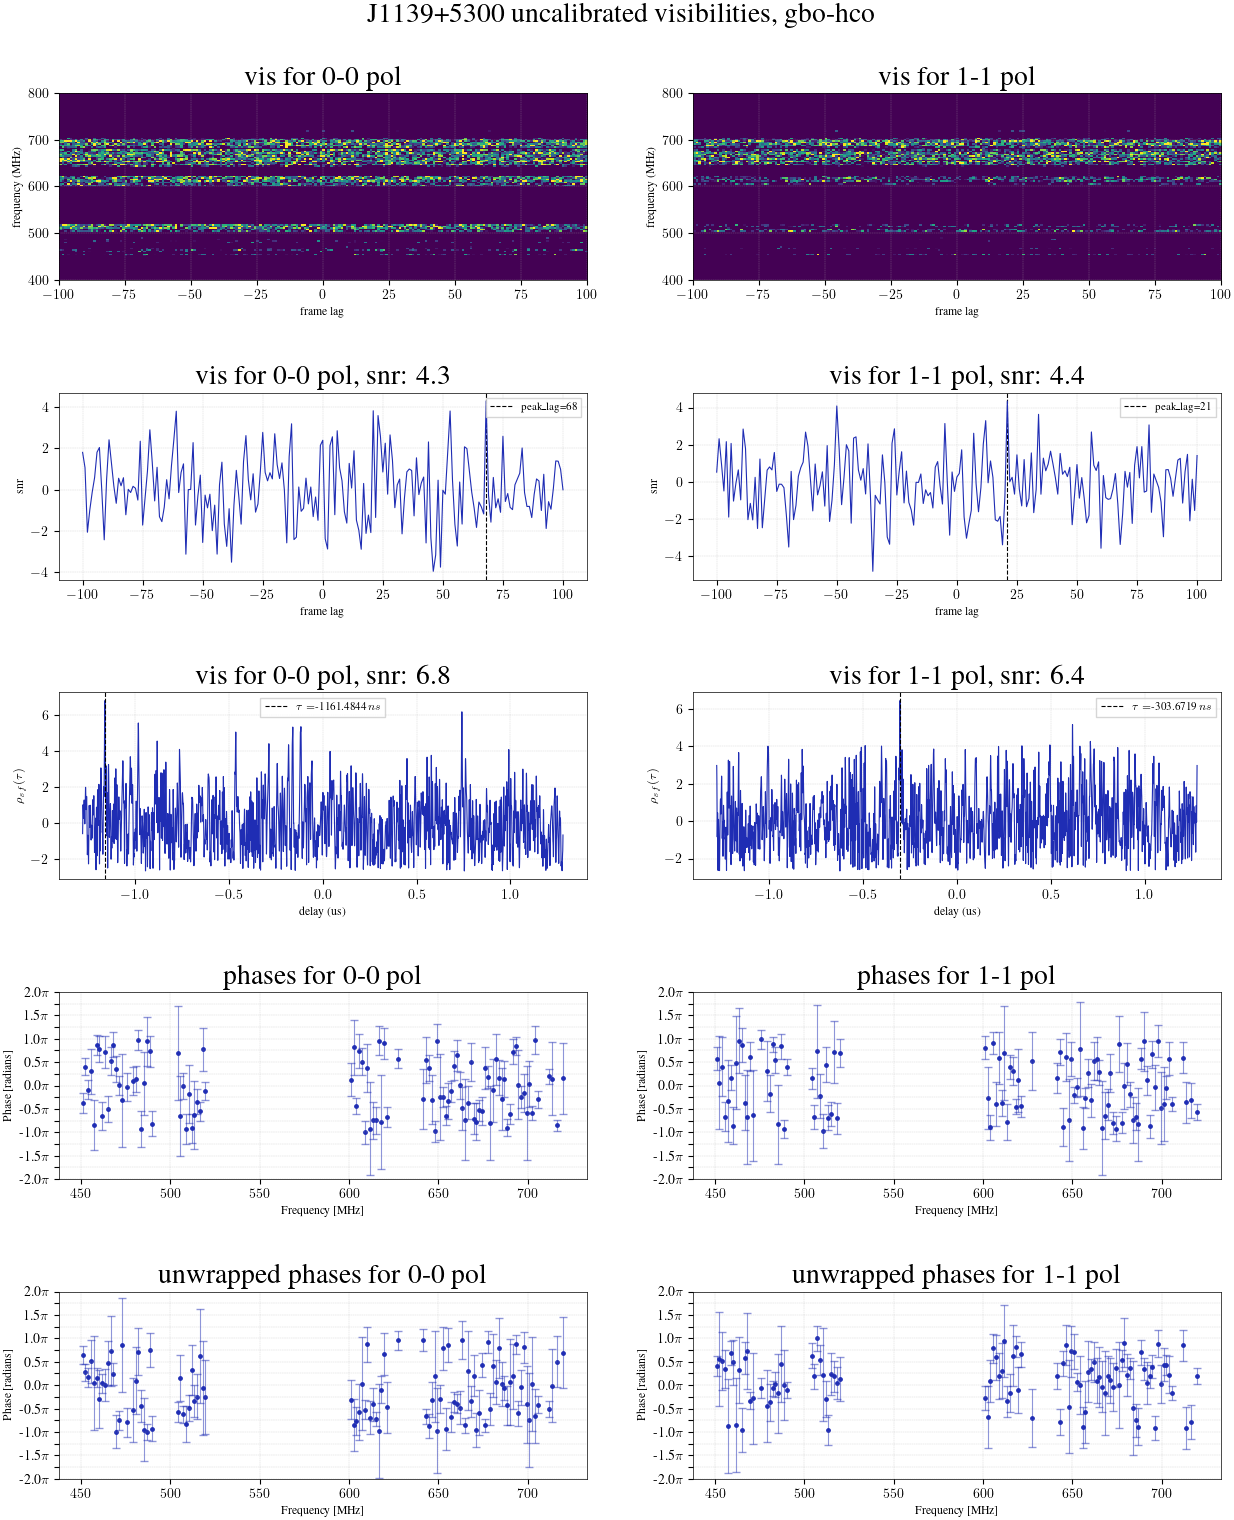

<Figure size 1200x600 with 0 Axes>

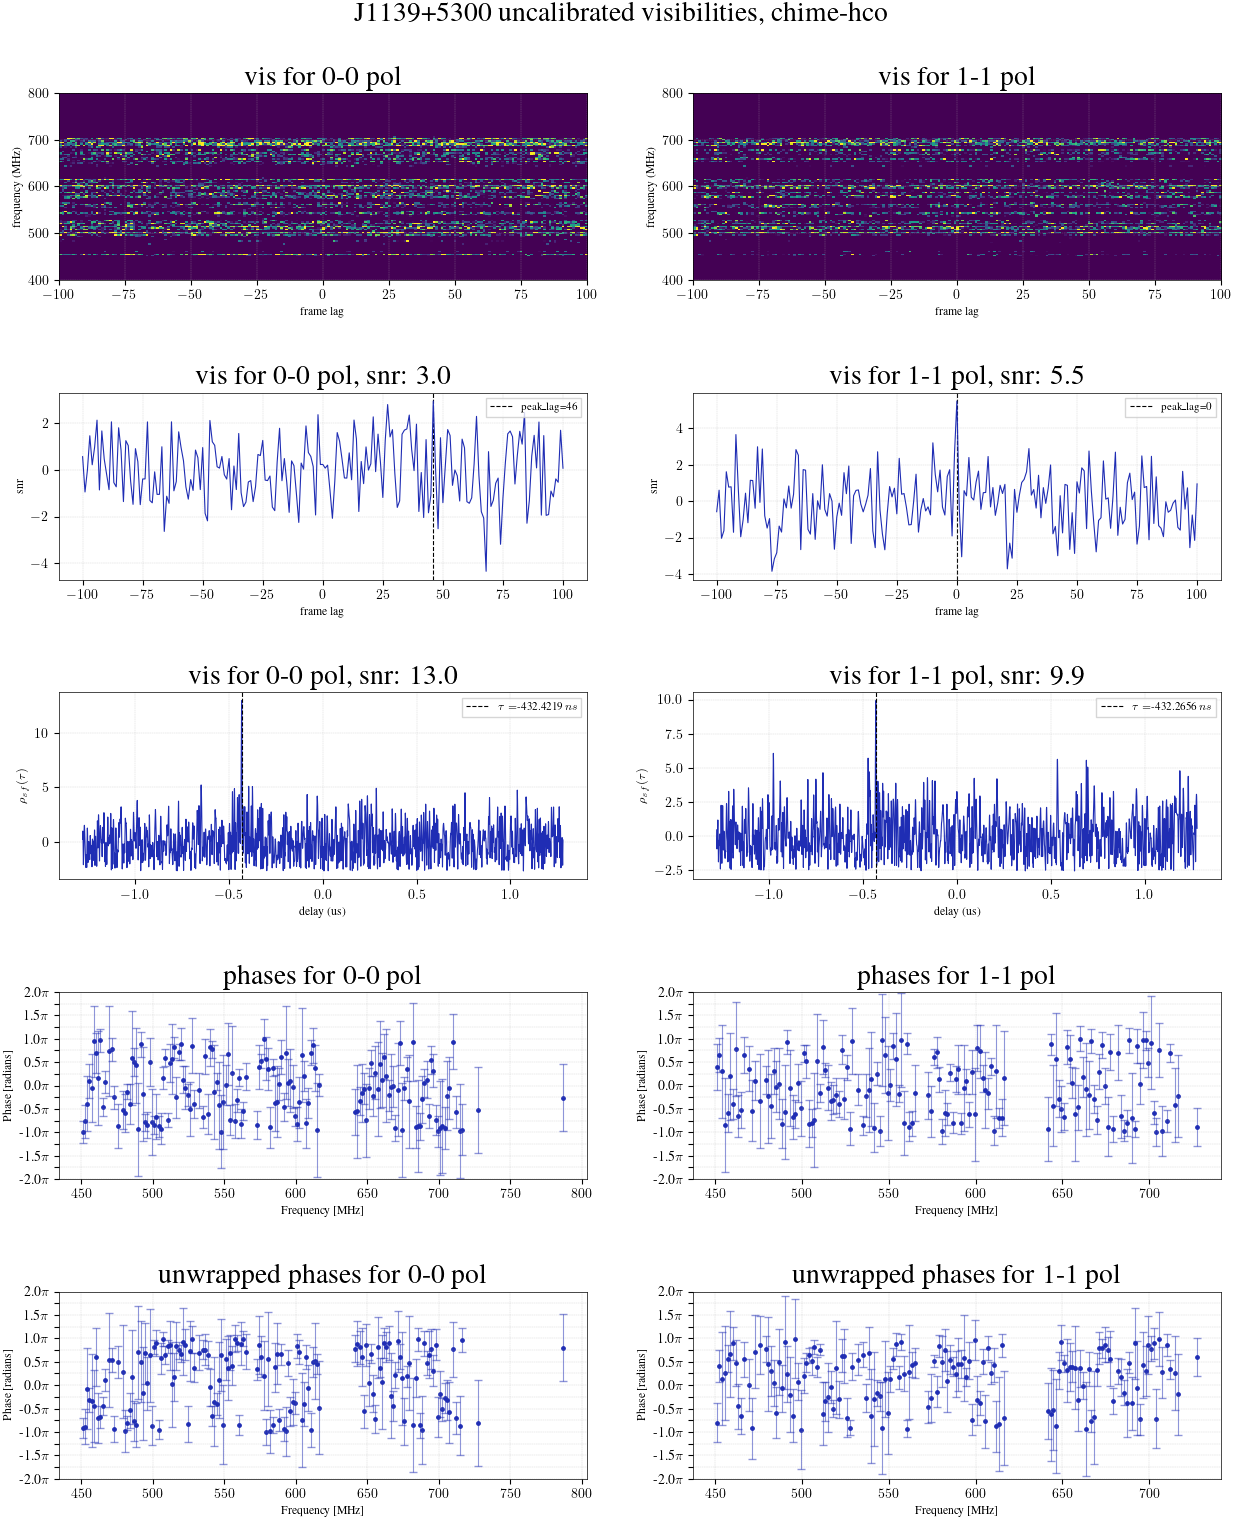

<Figure size 1200x600 with 0 Axes>

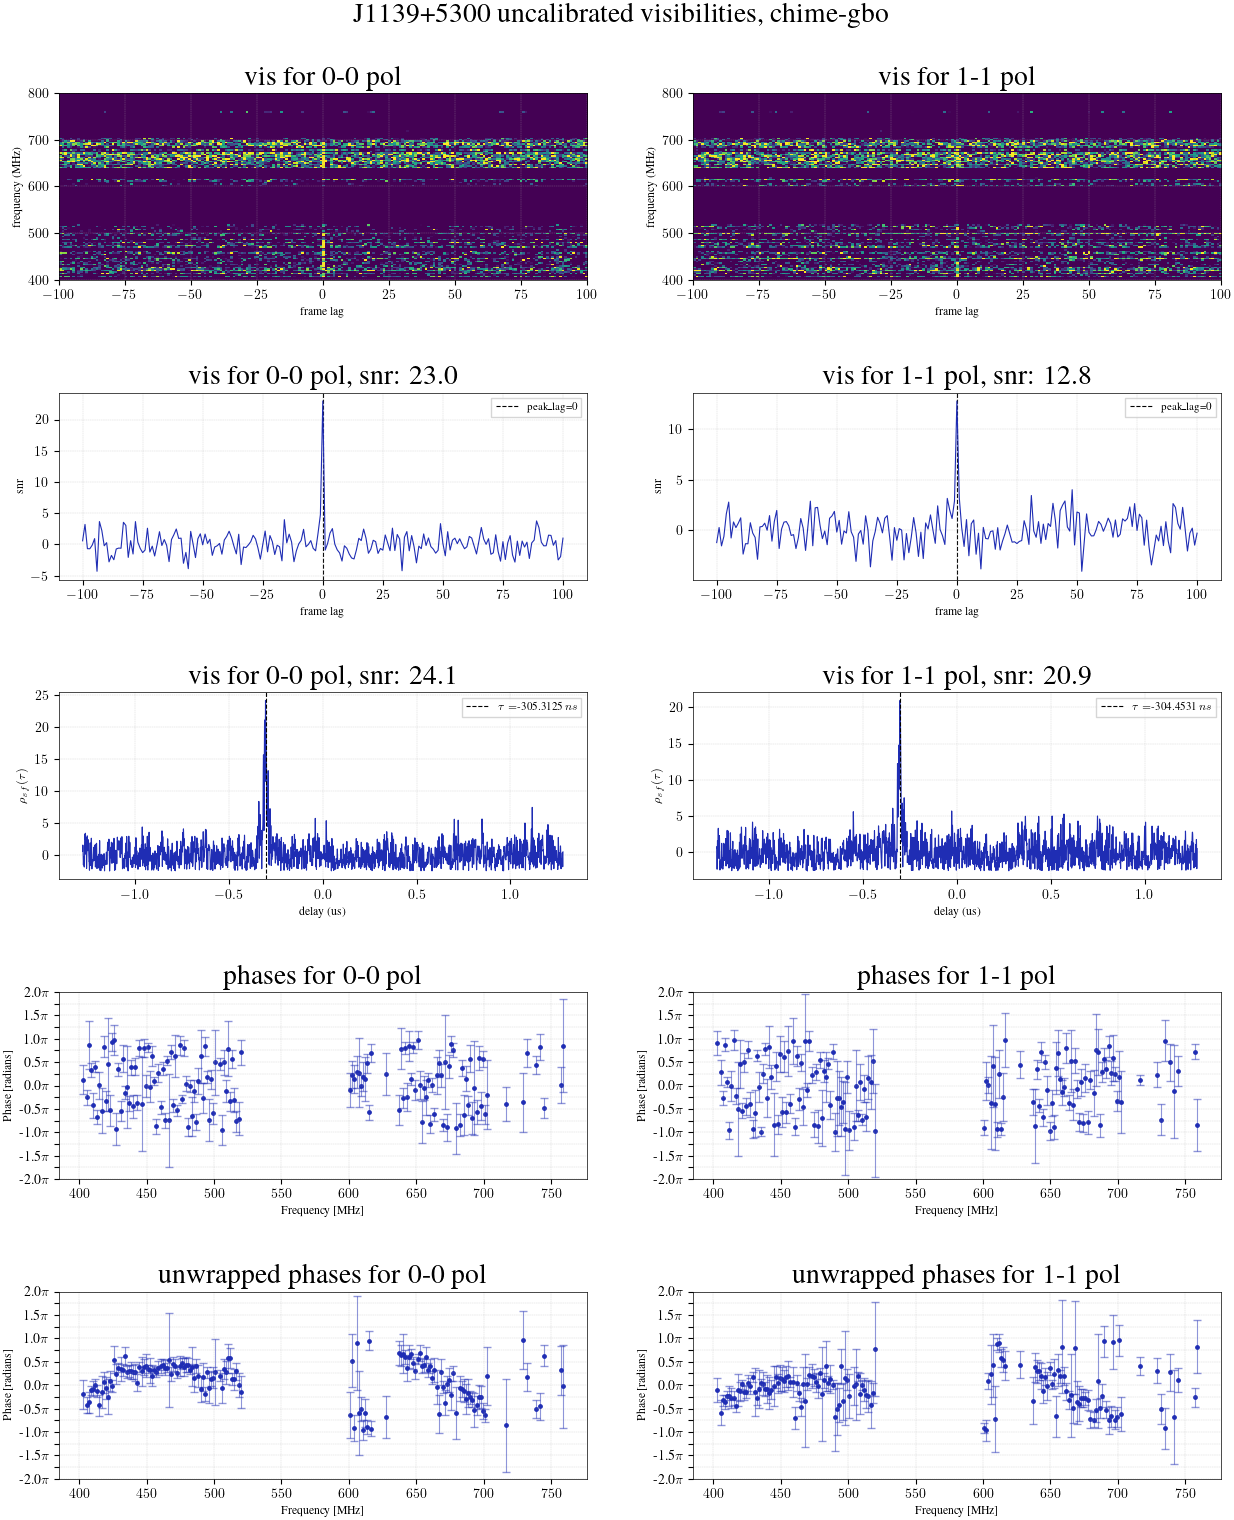

<Figure size 1200x600 with 0 Axes>

In [149]:


config.VERSION='manual_triggers'
eid=20250509042648
i=0
f=find_files(eid,data_type='visibilities',source_type='calibrator',filename_suffix='J1139+5300')[i]
#f=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/*')[i]
print(f)
vis=VLBIVis.from_file(f)
unmask_channels_single_baseline(vis['gbo-hco'])
mask=np.where((vis.freqs>520)&(vis.freqs<600))
vis['gbo-hco']['vis'][mask]=0.0
vis['chime-gbo']['vis'][mask]=0.0

mask=np.where((vis.freqs>720))
vis['gbo-hco']['vis'][mask]=0.0

mask=np.where((vis.freqs>490)&(vis.freqs<503))
vis['gbo-hco']['vis'][mask]=0.0
get_optimal_rfi_mask(vis['gbo-hco'], write=True, sub_integration_scan=0)
plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-hco',fscrunch=4)
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-gbo',fscrunch=4)

In [148]:
vis.save(f)

In [133]:

config.VERSION='manual_triggers'
eid=20250417054519
i=27
#f=find_files(eid,data_type='visibilities',source_type='calibrator')[0]
f=glob(f'/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/*')[i]
print(f)
vis=VLBIVis.from_file(f)
unmask_channels_single_baseline(vis['gbo-hco'])
mask=np.where((vis.freqs<560)&(vis.freqs>400))
vis['gbo-hco']['vis'][mask]=0.0
mask=np.where((vis.freqs>720))
vis['gbo-hco']['vis'][mask]=0.0
get_optimal_rfi_mask(vis['gbo-hco'], write=True, sub_integration_scan=0)

plot_visibility_diagnostics(vis,close=False,baseline_name='gbo-hco',fscrunch=4)
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-hco',fscrunch=4)
plot_visibility_diagnostics(vis,close=False,baseline_name='chime-gbo',fscrunch=4)

/arc/projects/chime_frb/vlbi/manual_triggers/M12_OVP_astrometry/calibrated/20250418054922/J1129+5025_calibrated_to_J1145+6958_vis.h5



KeyboardInterrupt



In [70]:
#vis.save(f)

In [69]:
f

'/arc/projects/chime_frb/vlbi/manual_triggers/2025/05/09/20250509042648/calibrator_visibilities/20250509042648_J1135+3708_vis.h5'

In [ ]:
#TBD 20250516040716
20250418054922
20250417054519
20250509042648
